### Referanslar

* https://www.kaggle.com/nareshbhat/outlier-the-silent-killer?select=train.csv
* https://neptune.ai/blog/anomaly-detection-in-time-series
* https://github.com/Vicam/Unsupervised_Anomaly_Detection
* https://github.com/Cem-Gulec/CSE4062S21_Grp8

### Giriş:

Karşılaştığımız probleme çözüm olarak belirlediğimiz farklı tipte algoritmalara ait derlediğimiz bilgilere aşağıdan ulaşabilirsiniz. Henüz anomaliler açısından “etiketli” veriye sahip olmadığımızdan bir kısmı kümeleme algoritmaları ve diğerleri de buna yakın amaca hizmet eden gözetimsiz öğrenim algoritmalarından yararlandık. Yazımızda, her birinin kullanım amacı, senaryoya olan katkılarına dair bilgiler aktarılacaktır.

# Uygulanan Algoritmalar:
- K-means
- Elliptic Enveloppe 
- Prophet Forecasting
- Markov Chains
- Isolation Forest
- Support Vector Machine
- LSTM 

In [1]:
#from fbprophet import Prophet
from matplotlib import pyplot as plt
import matplotlib.dates as md
import matplotlib.dates as dates
import numpy as np
import pandas as pd
#from pyemma import msm
from scipy.spatial.distance import cdist
import seaborn as sns
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from statsmodels.graphics.gofplots import qqplot

# 1 Data
## 1.1 Extract data

In [2]:
df = pd.read_csv("main_ApplyCreditApplication-statistics.txt")

## 1.2 Understand data

In [3]:
df.head()

,hour,value
0,2021-6-10 00:00:00,20
1,2021-6-10 01:00:00,6
2,2021-6-10 02:00:00,0
3,2021-6-10 03:00:00,0
4,2021-6-10 04:00:00,0


In [4]:
df.tail()

,hour,value
3268,2021-10-15 6:00:00,24
3269,2021-10-15 7:00:00,26
3270,2021-10-15 8:00:00,6
3271,2021-10-15 9:00:00,58
3272,2021-10-15 10:00:00,183


In [5]:
df.describe()

,value
count,3273.000000
mean,47.204400
std,50.592432
min,0.000000
25%,10.000000
50%,32.000000
75%,68.000000
max,436.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3273 entries, 0 to 3272
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   hour    3273 non-null   object
 1   value   3273 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 51.3+ KB


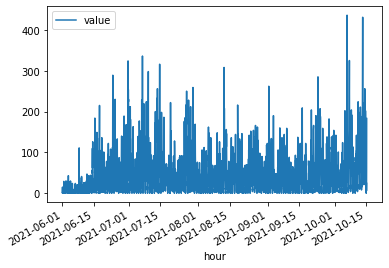

In [3]:
# change the type of hour column for plotting
df['hour'] = pd.to_datetime(df['hour'])

# plot the data
df.plot(x='hour', y='value')

# define certain size configurations for plotting
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100 

plt.show()

## Seasonal-trend decomposition based on seasonal, trend, and residue
Time series decomposition is a technique that splits a time series into several components, each representing an underlying pattern category, trend, seasonality, and noise. 

### Seasonality
Describes the periodic signal in your time series.

### Trend
Describes whether the time series is decreasing, constant, or increasing over time.

## Noise
Describes what remains behind the separation of seasonality and trend from the time series. In other words, it’s the variability in the data that cannot be explained by the model.

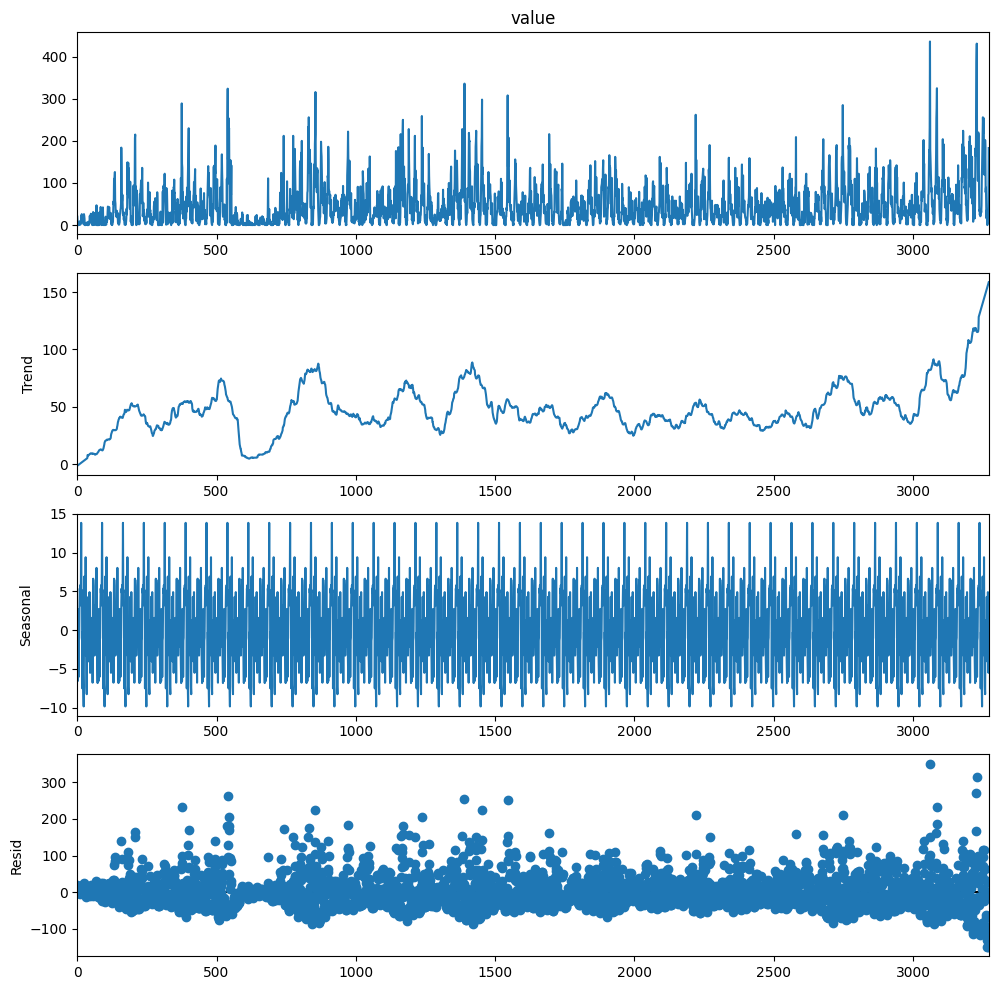

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose 

result_add = seasonal_decompose(x=df['value'], model='additive', extrapolate_trend='freq', period=75)
plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot().suptitle('', fontsize=22)
plt.show()

If we analyze the deviation of residue and introduce some threshold for it, we’ll get a representative anomaly detection algorithm.

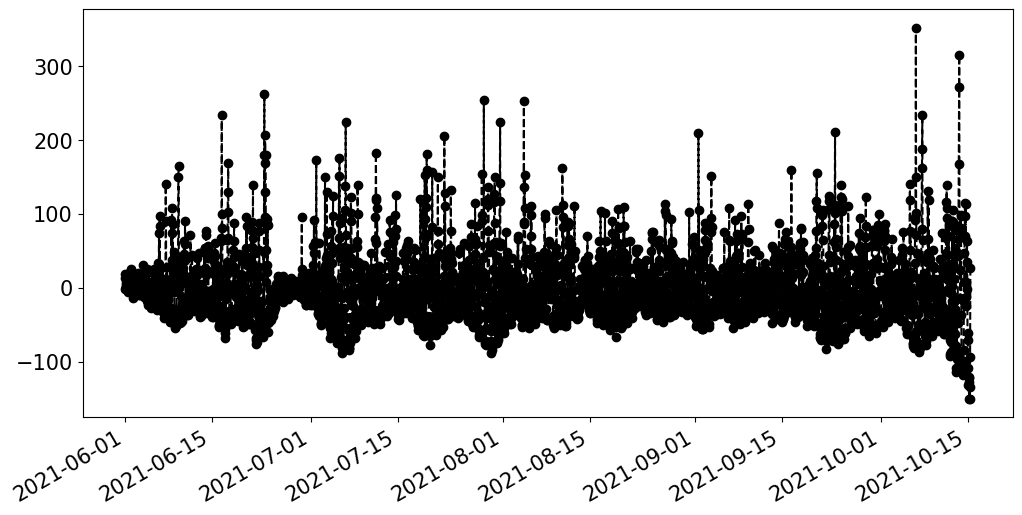

In [9]:
df = df.sort_values(by="hour")
plt.rc('figure',figsize=(12,6))
plt.rc('font',size=15)
fig, ax = plt.subplots()
y = result_add.resid.values
ax.plot_date(df.hour, y, color='black',linestyle='--')
fig.autofmt_xdate()
plt.show()

## 1.3 Feature engineering
Extracting some useful features

In [4]:
# timestamp to hours
df['hours'] = df['hour'].dt.hour

# declaring daylight on hours of 7,..,17
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 19)).astype(int)

In [5]:
# Monday=0,.., Sunday=6
df['DayOfTheWeek'] = df['hour'].dt.dayofweek

df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)

# An estimation of anomaly population of the dataset 
outliers_fraction = 0.01

In [6]:
# time with int to plot easily
df['time_epoch'] = (df['hour'].astype(np.int64)/100000000000).astype(np.int64)

C:\Users\Cem\AppData\Local\Temp/ipykernel_8836/1170427779.py:2: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  df['time_epoch'] = (df['hour'].astype(np.int64)/100000000000).astype(np.int64)


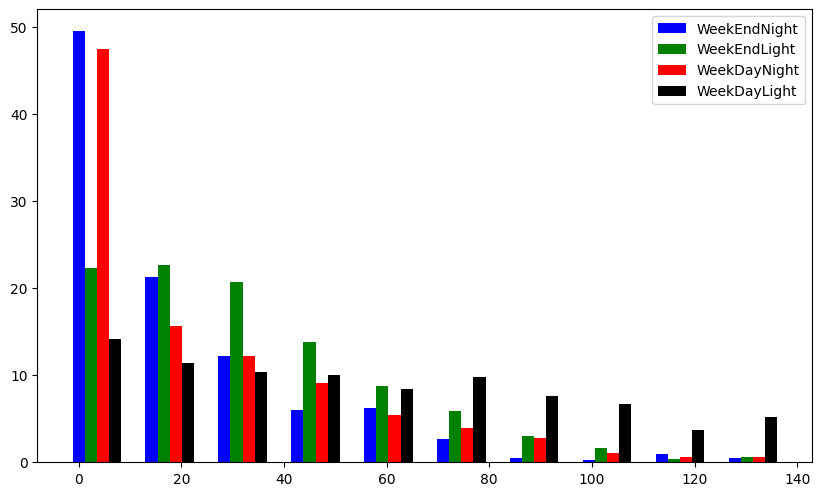

In [7]:
# creation of 4 distinct categories that seem useful (week end/day week & night/day)
df['categories'] = df['WeekDay']*2 + df['daylight']

a = df.loc[df['categories'] == 0, 'value']
b = df.loc[df['categories'] == 1, 'value']
c = df.loc[df['categories'] == 2, 'value']
d = df.loc[df['categories'] == 3, 'value']

fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='WeekEndNight')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='WeekEndLight')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='WeekDayNight')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='WeekDayLight')

plt.legend()
plt.show()

## 1.4 Basic Statistics Analysis

### 1.4.1 Z-Score Method

* 68% of the data points lie between + or - 1 standard deviation.
* 95% of the data points lie between + or - 2 standard deviation
* 99.7% of the data points lie between + or - 3 standard deviation

In [14]:
out=[]
def Zscore_outlier(values, df):
    m = np.mean(values)
    sd = np.std(values)
    for i in values: 
        z = (i-m)/sd
        if np.abs(z) > 3:
            out.append(df.loc[df['value'] == i]['hour'].values[0])
    out.sort()
    print(*out, sep="\n")
Zscore_outlier(df['value'], df)

2021-06-17T15:00:00.000000000
2021-06-17T15:00:00.000000000
2021-06-17T16:00:00.000000000
2021-06-17T16:00:00.000000000
2021-06-23T15:00:00.000000000
2021-06-24T16:00:00.000000000
2021-06-24T16:00:00.000000000
2021-06-30T10:00:00.000000000
2021-06-30T11:00:00.000000000
2021-06-30T14:00:00.000000000
2021-06-30T14:00:00.000000000
2021-06-30T14:00:00.000000000
2021-06-30T15:00:00.000000000
2021-06-30T15:00:00.000000000
2021-06-30T15:00:00.000000000
2021-07-01T01:00:00.000000000
2021-07-01T01:00:00.000000000
2021-07-01T01:00:00.000000000
2021-07-06T14:00:00.000000000
2021-07-06T14:00:00.000000000
2021-07-06T22:00:00.000000000
2021-07-07T14:00:00.000000000
2021-07-07T14:00:00.000000000
2021-07-07T14:00:00.000000000
2021-07-07T16:00:00.000000000
2021-07-07T16:00:00.000000000
2021-07-07T16:00:00.000000000
2021-07-09T12:00:00.000000000
2021-07-09T12:00:00.000000000
2021-07-09T13:00:00.000000000
2021-07-13T13:00:00.000000000
2021-07-13T15:00:00.000000000
2021-07-13T15:00:00.000000000
2021-07-14

### 1.4.2 IQR Method

In [15]:
out=[]
def iqr_outliers(values, df):
    q1 = values.quantile(0.25)
    q3 = values.quantile(0.75)
    iqr = q3-q1
    Lower_tail = q1 - 1.5 * iqr
    Upper_tail = q3 + 1.5 * iqr
    for i in values:
        if i > Upper_tail or i < Lower_tail:
            out.append(df.loc[df['value'] == i]['hour'].values[0])
    out.sort()
    print(*out, sep='\n')
iqr_outliers(df['value'], df)

2021-06-15T14:00:00.000000000
2021-06-15T14:00:00.000000000
2021-06-15T14:00:00.000000000
2021-06-15T14:00:00.000000000
2021-06-15T14:00:00.000000000
2021-06-15T14:00:00.000000000
2021-06-17T15:00:00.000000000
2021-06-17T15:00:00.000000000
2021-06-17T16:00:00.000000000
2021-06-17T16:00:00.000000000
2021-06-23T15:00:00.000000000
2021-06-24T15:00:00.000000000
2021-06-24T15:00:00.000000000
2021-06-24T15:00:00.000000000
2021-06-24T16:00:00.000000000
2021-06-24T16:00:00.000000000
2021-06-28T16:00:00.000000000
2021-06-28T16:00:00.000000000
2021-06-28T16:00:00.000000000
2021-06-28T16:00:00.000000000
2021-06-29T15:00:00.000000000
2021-06-30T10:00:00.000000000
2021-06-30T11:00:00.000000000
2021-06-30T12:00:00.000000000
2021-06-30T12:00:00.000000000
2021-06-30T12:00:00.000000000
2021-06-30T13:00:00.000000000
2021-06-30T13:00:00.000000000
2021-06-30T13:00:00.000000000
2021-06-30T13:00:00.000000000
2021-06-30T14:00:00.000000000
2021-06-30T14:00:00.000000000
2021-06-30T14:00:00.000000000
2021-06-30

### 1.4.3 WINSORIZATION METHOD (PERCENTILE CAPPING)

In [16]:
out=[]
def Winsorization_outliers(values, df):
    q1 = np.percentile(values , 1)
    q3 = np.percentile(values , 99)
    for i in values:
        if i > q3 or i < q1:
            out.append(df.loc[df['value'] == i]['hour'].values[0])
    print(*out, sep="\n")
Winsorization_outliers(df['value'], df)

2021-06-23T15:00:00.000000000
2021-06-24T16:00:00.000000000
2021-06-30T10:00:00.000000000
2021-06-30T11:00:00.000000000
2021-06-30T14:00:00.000000000
2021-06-30T15:00:00.000000000
2021-06-24T16:00:00.000000000
2021-07-06T14:00:00.000000000
2021-07-06T22:00:00.000000000
2021-06-30T15:00:00.000000000
2021-07-09T13:00:00.000000000
2021-07-13T13:00:00.000000000
2021-07-13T15:00:00.000000000
2021-07-14T15:00:00.000000000
2021-07-19T12:00:00.000000000
2021-07-26T17:00:00.000000000
2021-07-06T14:00:00.000000000
2021-07-29T13:00:00.000000000
2021-08-12T12:00:00.000000000
2021-09-01T13:00:00.000000000
2021-09-23T14:00:00.000000000
2021-10-06T14:00:00.000000000
2021-10-06T15:00:00.000000000
2021-06-30T14:00:00.000000000
2021-10-07T15:00:00.000000000
2021-10-07T16:00:00.000000000
2021-06-30T15:00:00.000000000
2021-10-13T13:00:00.000000000
2021-10-13T14:00:00.000000000
2021-10-13T15:00:00.000000000
2021-07-13T15:00:00.000000000
2021-10-14T14:00:00.000000000
2021-06-30T14:00:00.000000000


### 1.4.4 Visualization

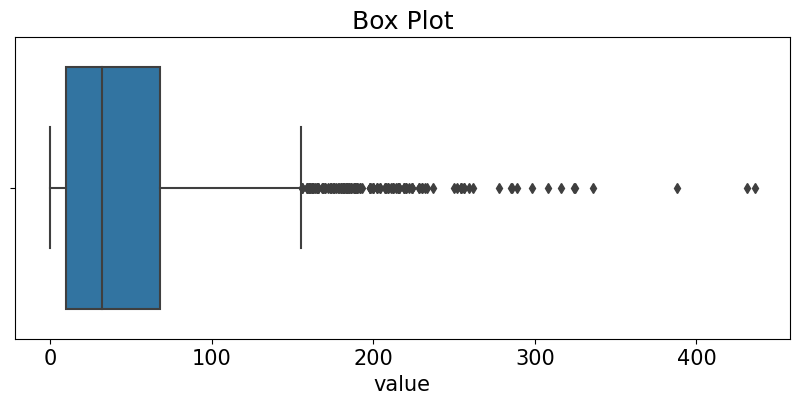

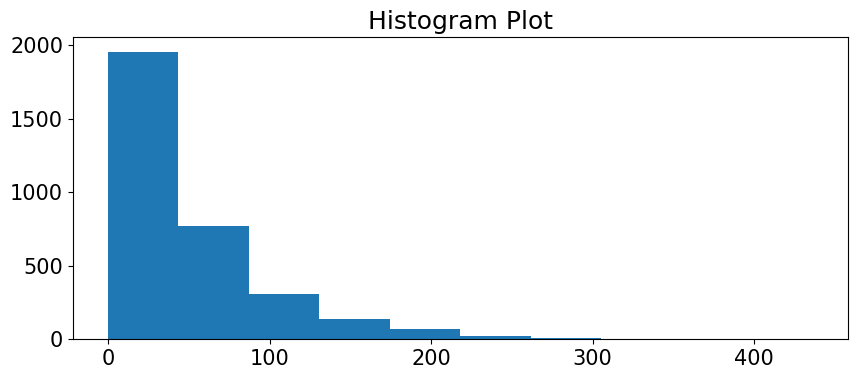

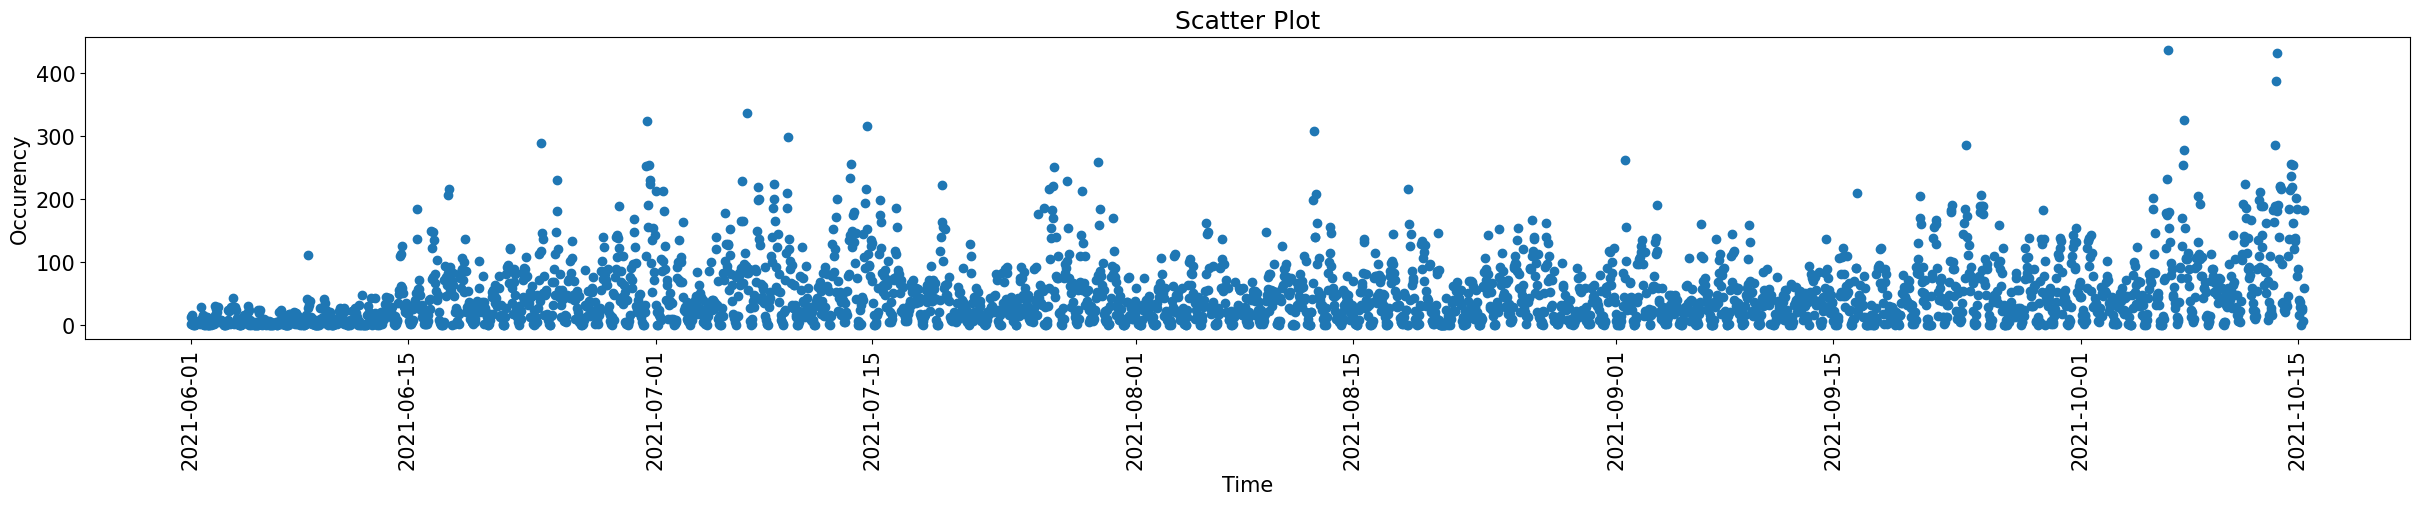

<Figure size 1000x400 with 0 Axes>

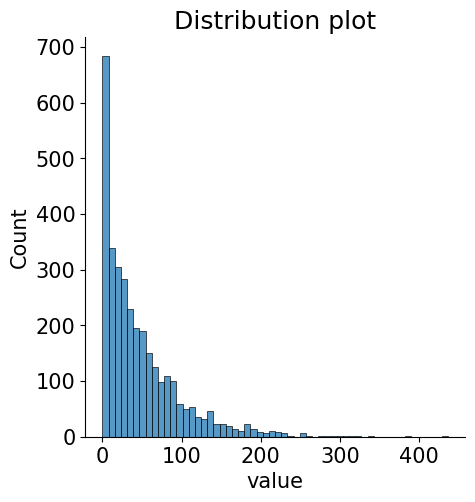

c:\users\cem\appdata\local\programs\python\python39\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


<Figure size 1000x400 with 0 Axes>

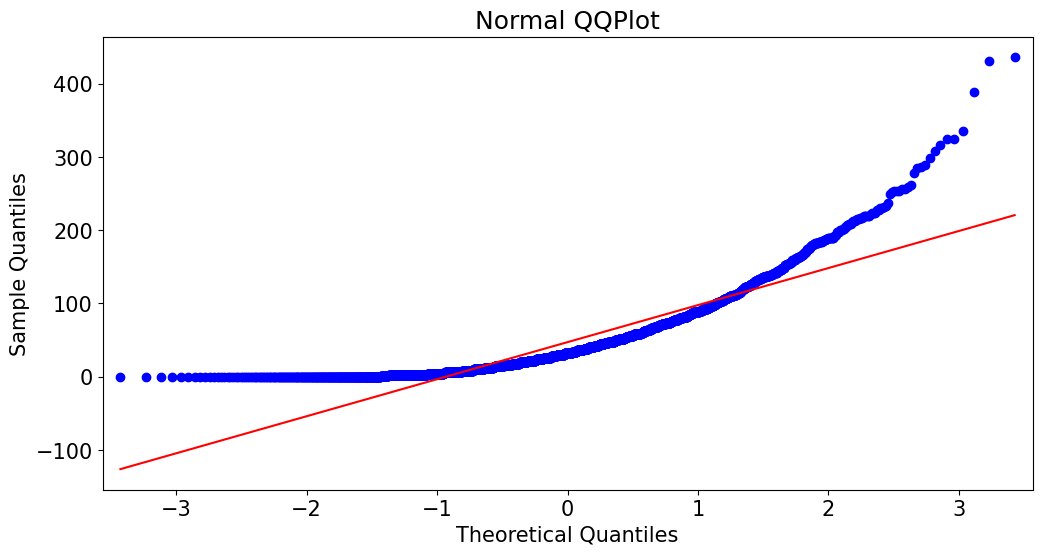

In [17]:
def Box_plots(df):
    plt.figure(figsize=(10, 4))
    plt.title("Box Plot")
    sns.boxplot(x=df)
    plt.show()

def hist_plots(df):
    plt.figure(figsize=(10, 4))
    plt.hist(df)
    plt.title("Histogram Plot")
    plt.show()

def scatter_plots(df1,df2):
    fig, ax = plt.subplots(figsize=(30,4))
    ax.scatter(df1,df2)
    ax.set_xlabel('Time')
    ax.set_ylabel('Occurency')
    plt.title("Scatter Plot")
    plt.xticks(rotation=90)
    plt.show()

def dist_plots(df):
    plt.figure(figsize=(10, 4))
    sns.displot(df)
    plt.title("Distribution plot")
    sns.despine()
    plt.show()

def qq_plots(df):
    plt.figure(figsize=(10, 4))
    qqplot(df,line='s')
    plt.title("Normal QQPlot")
    plt.show()

Box_plots(df['value'])
hist_plots(df['value'])
scatter_plots(df['hour'], df['value'])
dist_plots(df['value'])
qq_plots(df['value'])

# 2 Models
## 2.1 K-means 

Probleme ait senaryomuzda herhangi etiketli veri bulunmadığından, veriyi analiz etmek adına kümeleme metodundan yararlandık. Bu metodda “kümeleme” olarak bahsedilen terim, aynı alt gruptaki (küme) veri noktaları çok benzerken, farklı kümelerdeki veri noktaları çok farklı olacak şekilde, verilerdeki alt grupları belirleme görevi olarak tanımlanabilir. Bu sayede oluşacak kümeler dışında kalacak tekil noktaları anomali olarak tespit etmek gayet kolay olacaktır. <br>
Kümeleme algoritmaları denildiğinde kendinden en çok söz ettiren algoritmalardan birisi Kmeans algoritmasıdır. Kmeans tekrarlı olarak çalışarak her bir adımda kümelere ait merkezleri günceller ve buna bağlı olarak her adımın başlangıcında verileri en yakın oldukları kümelerle eşleştirir. Kümelerde herhangi bir değişim olmayıncaya kadar algoritma çalışmaya devam eder. <br><br>
Burada, Kmeans algoritmasının eksik kaldığı şu noktayı belirtmek gerekir ki: algoritma negatif anomali olarak nitelendirebileceğimiz, trendin altında kalan sert düşüşlere ait noktaları tespit etmekte pek de başarılı olamamıştır. Bunun ana sebepleri olarak, algoritmanın girdi olarak verilen küme sayısına bağımlı olmasına ve kümeleme mantığını oluştururken “önemli” olarak kullanılan parametrelerin negatif trendi o kadar da trend dışı kabul etmemesine bağlayabiliriz. Farklı küme değerleri ve farklı parametrelerle oluşturulan denemelerimize devam etmekteyiz. 

In [18]:
# return Series of distance between each point and his distance with the closest centroid
def getDistanceByPoint(data, model):
    distance = pd.Series(dtype='float64')
    cluster_cnt = model.labels_.max()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        dist = []
        for j in range(0,cluster_cnt):
            if model.labels_[i] != j:
                Xb = model.cluster_centers_[j]
                dist.append(np.linalg.norm(Xa-Xb))
        distance.at[i] = min(dist)
    return distance

### Applying PCA to extract most important features

Below article is in my opinion is very useful in regard to both understanding PCA and observing recent developments in the area:
https://royalsocietypublishing.org/doi/10.1098/rsta.2015.0202

In [19]:
# Take useful feature and standardize them to unit variance
# z = (x - u) / s
# x: given sample 
# u: mean of the training samples
# s: standard deviation of the training samples
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

# reduce to 2 importants features
pca = PCA(n_components=2)
data = pca.fit_transform(data)

# standardize these 2 new features
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

En uygun küme sayısını seçmek adına distortion değerleri ile çizilen grafik üzerinde Elbow Method'undan, silhouette score, hata kareler toplamı (SSE), standart sapma, normalized mutual info score gibi metriklerden yararlanılmıştır. <br> 
Tabii ki değişiklik gösterebilir fakat, bu veri seti özelinde 4 cluster sayısının en uygun olacağına karar verdik.

In [20]:
# see below link for a detailed explanation for distortion calculation and its application
# https://s3.amazonaws.com/assets.datacamp.com/production/course_14739/slides/chapter3.pdf

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 20)
 
for k in K:
    # Building and training the model
    kmeanModel = KMeans(n_clusters=k).fit(data)
    kmeanModel.fit(data)
 
    distortions.append(sum(np.min(cdist(data, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / data.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(data, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / data.shape[0]
    mapping2[k] = kmeanModel.inertia_

In [21]:
# Distortion values are displayed
for key, val in mapping1.items():
    print(f'{key} : {val}')

1 : 1.3034062955981636
2 : 0.9157286333163223
3 : 0.6233638019640743
4 : 0.5053664061621903
5 : 0.41379902385473294
6 : 0.3774185076659098
7 : 0.3444223437163198
8 : 0.3173852104070502
9 : 0.2875031245271123
10 : 0.2624082687959873
11 : 0.2525661874975374
12 : 0.2420796585019677
13 : 0.23487040322557476
14 : 0.22789639537269724
15 : 0.21968774424030882
16 : 0.21116971149540026
17 : 0.20306184457710963
18 : 0.19894421920374722
19 : 0.19376938793126847


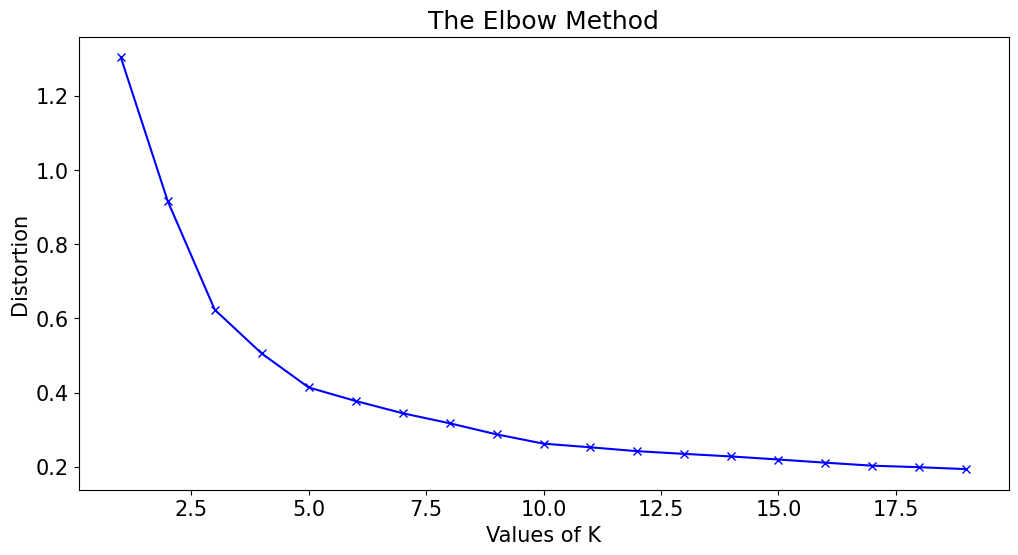

In [22]:
# Elbow method which is created with distortion values

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method')
plt.show()

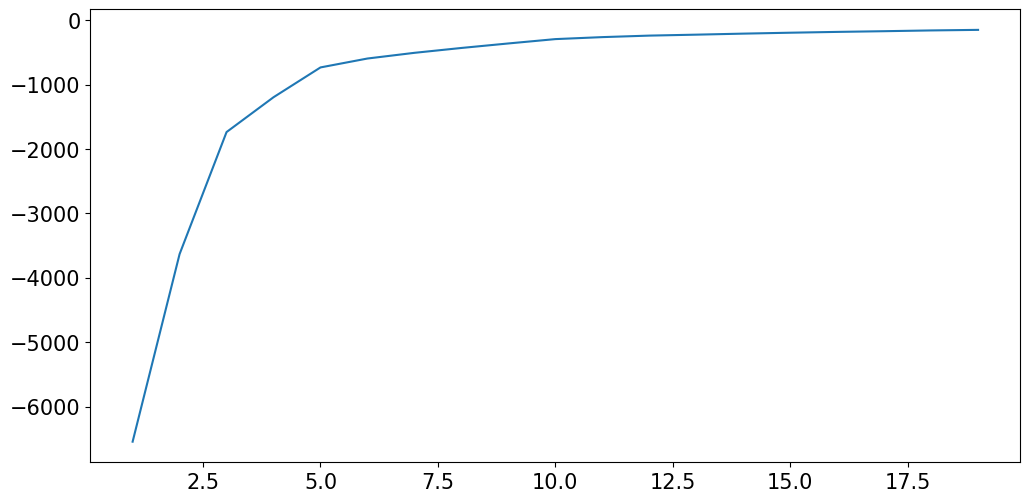

In [23]:
# calculate with different number of centroids to see the loss plot (elbow method)
# In theory most useful one is selected depending on where the curvature goes near zero, which in this is case is 5
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]

fig, ax = plt.subplots()
ax.plot(n_cluster, scores)

plt.show()

### Measuring Silhouette Score
The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). Value ranges from -1 to 1.
* 1: Means clusters are well apart from each other and clearly distinguished.
* 0: Means clusters are indifferent, or we can say that the distance between clusters is not significant.
* -1: Means clusters are assigned in the wrong way.

[0.49190890419962435, 0.5668460786718349, 0.6047295802081566, 0.5544385367294373, 0.5276604348597952, 0.5362222594015511, 0.5038434231246357, 0.4759763231991929, 0.4798290710784634, 0.4770152164513463, 0.47263928339638533, 0.45484191930804724, 0.43868756261344993, 0.4226825790664061, 0.4173196634900637, 0.42430677423233903, 0.4263225605078718, 0.4211263379063647]
Max silhouette coeficient for df is 0.6047295802081566 for 4 cluster


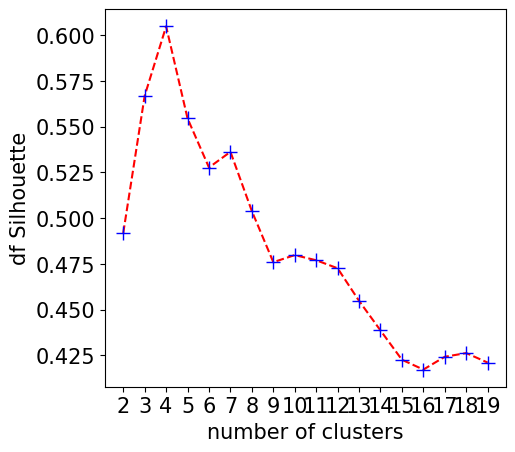

Runtime of KMeans algorithm:  3.8520625000000024


In [24]:
# A clear explanation can be found at:
# https://dzone.com/articles/kmeans-silhouette-score-explained-with-python-exam
# Below similar to analysis on the distortion value, this time silhouette score is analyzed with their corresponding cluster values

import timeit
import sklearn.metrics as metrics

# K-means parameter scan
start = timeit.default_timer()
plt.figure(figsize=(30,5))

X_list = {'df': data}
i = 0

for x_str, x in X_list.items():
    silhouette_list = []
    i = i+1
    # Running K-means algorithm with 2 to 20 number of clusters and training for each of them
    for k in range(2, 20):
        kmeans_fit = KMeans(n_clusters=k).fit(x)
        y_pred = kmeans_fit.predict(x)
        silhouette_list.append(metrics.silhouette_score(x, y_pred, metric='euclidean'))
    plt.subplot(1,5,i)
    plt.plot(range(2, 20),silhouette_list, marker = '+',color = 'red' , ls = '--', markeredgecolor = 'blue', markersize = '10')
    plt.ylabel(x_str+' Silhouette')
    plt.xlabel('number of clusters')
    plt.xticks(np.arange(2, 20, 1))
    max_s = max(silhouette_list)
    max_k = silhouette_list.index(max_s) + 2
    print(silhouette_list)
    print('Max silhouette coeficient for {} is {} for {} cluster'.format(x_str, max_s, max_k))

plt.show()
stop = timeit.default_timer()
print('Runtime of KMeans algorithm: ', stop - start)

In [25]:
# I choose 4 centroids arbitrarily and add these data to the central dataframe
df['cluster'] = kmeans[3].predict(data)

# Best 2 feature after applying PCA method 
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]

# Display each point assigned to each cluster
df['cluster'].value_counts()

0    1660
2     701
1     647
3     265
Name: cluster, dtype: int64

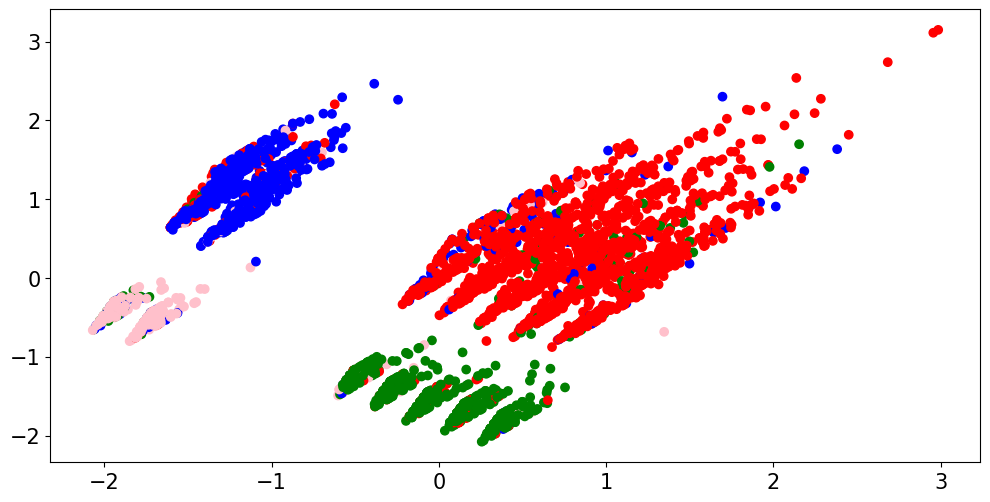

In [26]:
# plot the different clusters with the 2 main features
fig, ax = plt.subplots()

# color pallette
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple'}

# Only correlating the principal features grouping each data point to a cluster
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]))

plt.show()

In [27]:
# get the distance between each point and its nearest centroid. 
# Naturally, the biggest distances can be considered as anomaly
distance = getDistanceByPoint(data, kmeans[3])
number_of_outliers = int(outliers_fraction*len(distance))

# Take the minimum of the largest x% of the distances as the threshold
threshold = distance.nlargest(number_of_outliers).min()

# adding another column named "anomaly21" indicating anomalies found in the K-means method 
df['anomaly21'] = (distance >= threshold).astype(int)

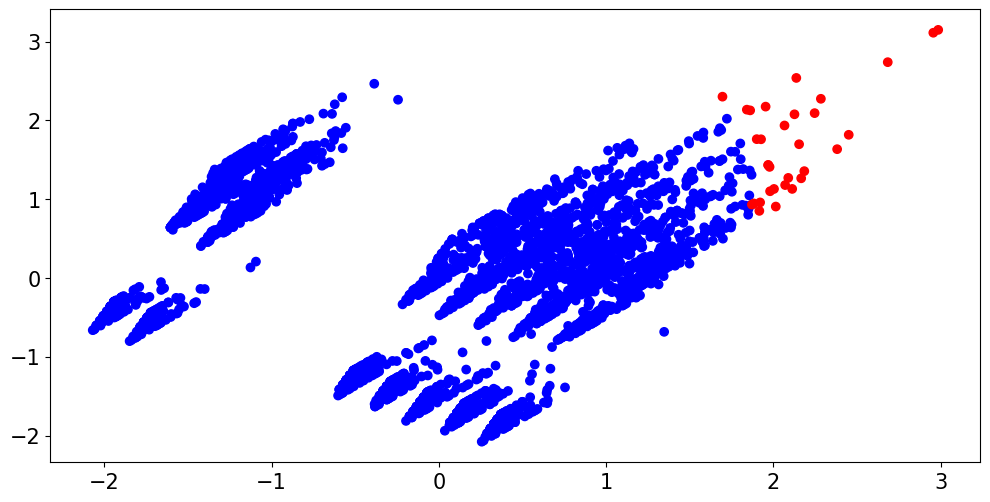

In [28]:
# Categorizing normal data and anomaly data from the whole dataset
# blue: normal data point (assigned to some cluster)
# red: anomaly point
fig, ax = plt.subplots()
colors = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly21"].apply(lambda x: colors[x]))

plt.show()

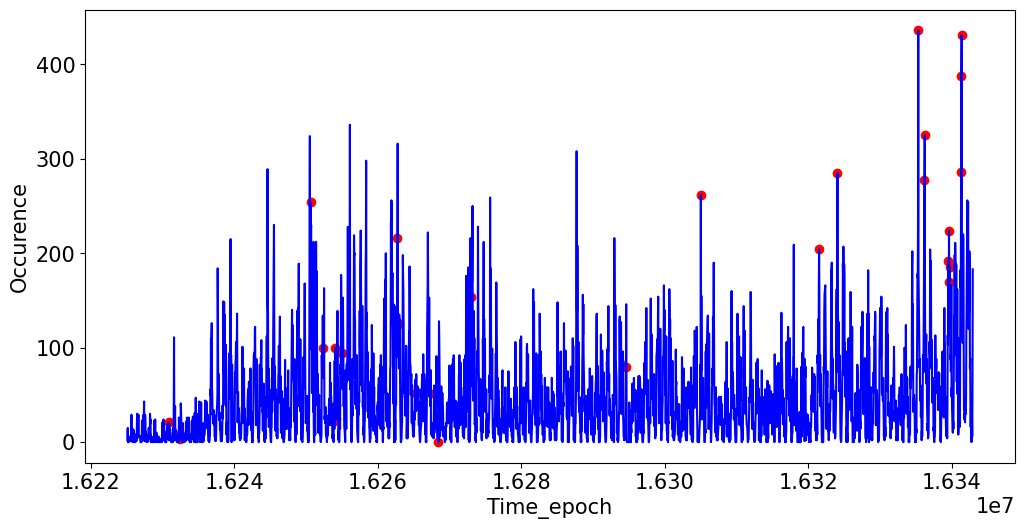

In [29]:
# Categorization plot of the dataset where anomaly and normal data is seperated
fig, ax = plt.subplots()
ax.set_xlabel("Time_epoch") # Timestamp
ax.set_ylabel("Occurence")  # Web credit application number

# anomaly
a = df.loc[df['anomaly21'] == 1, ['time_epoch', 'value']] 

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'], a['value'], color='red')

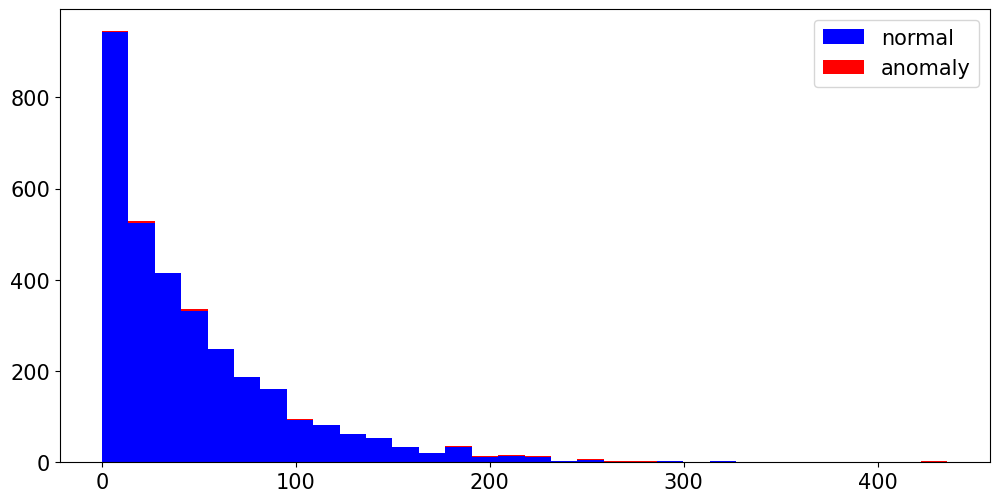

In [30]:
a = df.loc[df['anomaly21'] == 0, 'value']
b = df.loc[df['anomaly21'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])

plt.legend()
plt.show()

In [31]:
# Displaying only those rows where K-means detected some data as anomaly

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(df[df['anomaly21'] == 1])

                    hour  value  hours  daylight  DayOfTheWeek  WeekDay  \
664  2021-06-07 16:00:00     21     16         1             0        1   
707  2021-06-09 11:00:00      9     11         1             2        1   
710  2021-06-09 14:00:00      3     14         1             2        1   
543  2021-06-30 14:00:00    254     14         1             2        1   
1047 2021-07-02 15:00:00    100     15         1             4        1   
1329 2021-07-04 09:00:00     22      9         1             6        0   
1334 2021-07-04 14:00:00    100     14         1             6        0   
1336 2021-07-04 16:00:00     24     16         1             6        0   
1337 2021-07-04 17:00:00     39     17         1             6        0   
1358 2021-07-05 14:00:00     94     14         1             0        1   
854  2021-07-14 14:00:00    216     14         1             2        1   
862  2021-07-14 22:00:00    125     22         0             2        1   
925  2021-07-17 13:00:00 

In [32]:
# Creating a dictionary for counting same anomalies found from different algorithms/methods
timestamp_dict = {}

anomaly21_df = df[df['anomaly21'] == 1].hour
      
# Since this is applied for the first time, assign 1 to those indicated as anomaly
for index, value in anomaly21_df.items():
    timestamp_dict[value] = 1

In [33]:
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import adjusted_rand_score

# This method creates pie chart for an individual k valued cluster
# It seperates each data to corresponding cluster and returns its total counter
def pie_chart(l, labels, colors, k):

    nb_samples = [sum(l == j) for j in range(k)]

    fig1, ax1 = plt.subplots(figsize=(8,8))
    flavor_pie = ax1.pie(nb_samples,labels=labels, autopct='%.0f%%', shadow=True, colors=colors, 
                     startangle= -90, textprops={'fontsize': 18})

    centre_circle = plt.Circle((0,0),0.20,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    ax1.axis('equal')  
    plt.tight_layout()
    return plt.show()



Cluster Lengths With k=:  2
Counter({0: 2361, 1: 912})
SSE:  3632.351608901149
STD:  0.4483316586738446
NMI:  0.0012765643861980098
Rand Index:  -0.005103423355435899


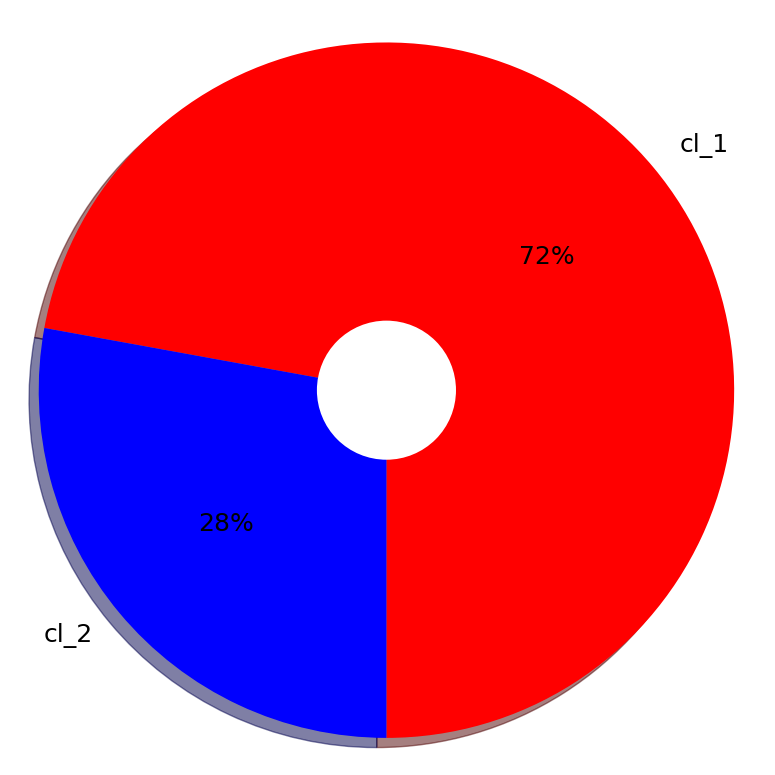



Cluster Lengths With k=:  3
Counter({1: 1660, 0: 912, 2: 701})
SSE:  1736.8441571318986
STD:  0.6990451115824075
NMI:  0.003093022483827951
Rand Index:  -0.0044589993152930356


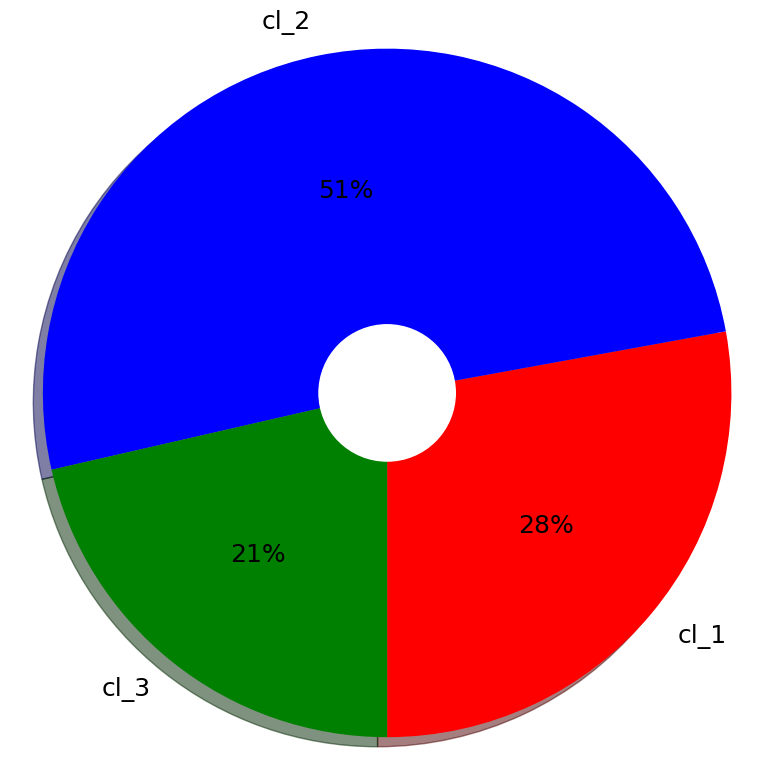



Cluster Lengths With k=:  4
Counter({2: 1660, 1: 701, 0: 647, 3: 265})
SSE:  1195.9160219294406
STD:  0.8980372016913308
NMI:  0.0035182208565927168
Rand Index:  -0.00540110895136634


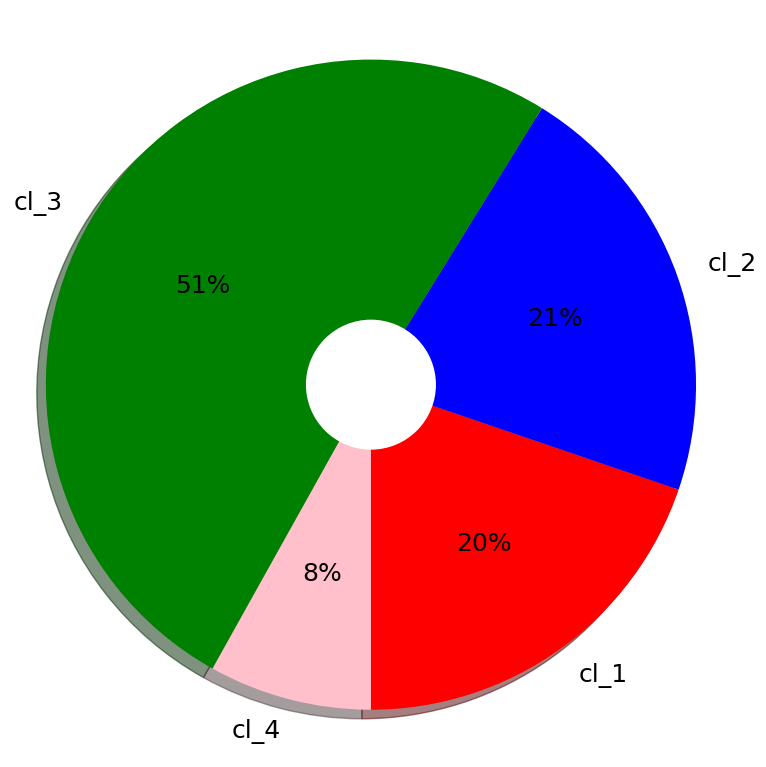



Cluster Lengths With k=:  5
Counter({4: 1005, 2: 689, 0: 667, 1: 647, 3: 265})
SSE:  733.0246094023341
STD:  1.521170613996881
NMI:  0.005985842222197179
Rand Index:  0.00042324766768718226


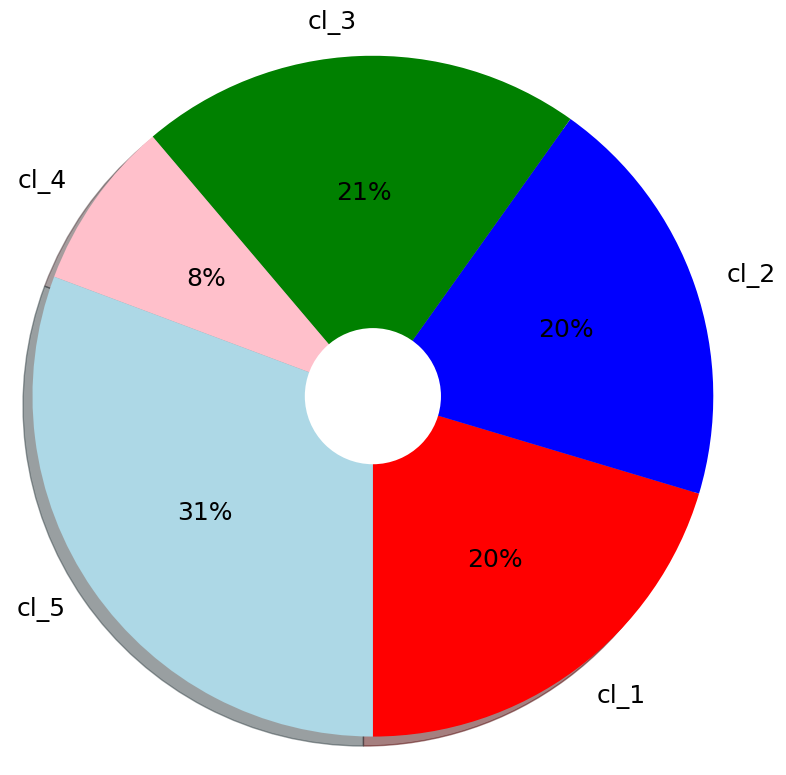



Cluster Lengths With k=:  6
Counter({0: 726, 5: 707, 2: 689, 1: 647, 4: 265, 3: 239})
SSE:  594.611600885704
STD:  1.8350756067186105
NMI:  0.008727720182951947
Rand Index:  0.002482437226154263


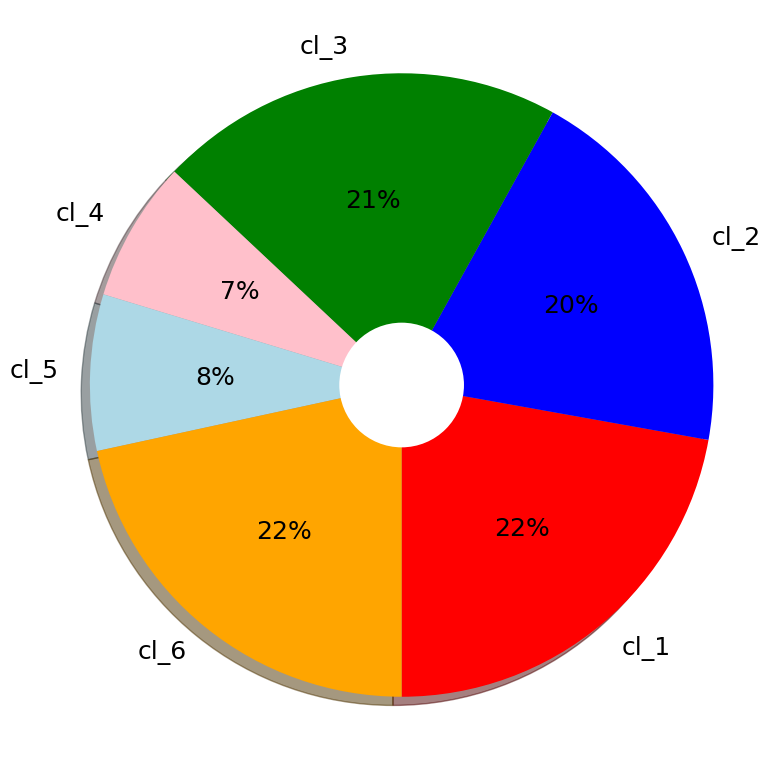



Cluster Lengths With k=:  7
Counter({3: 688, 4: 647, 0: 639, 5: 412, 1: 398, 2: 265, 6: 224})
SSE:  503.2351652719793
STD:  1.891171117120128
NMI:  0.008303882995779359
Rand Index:  0.002218287735247655


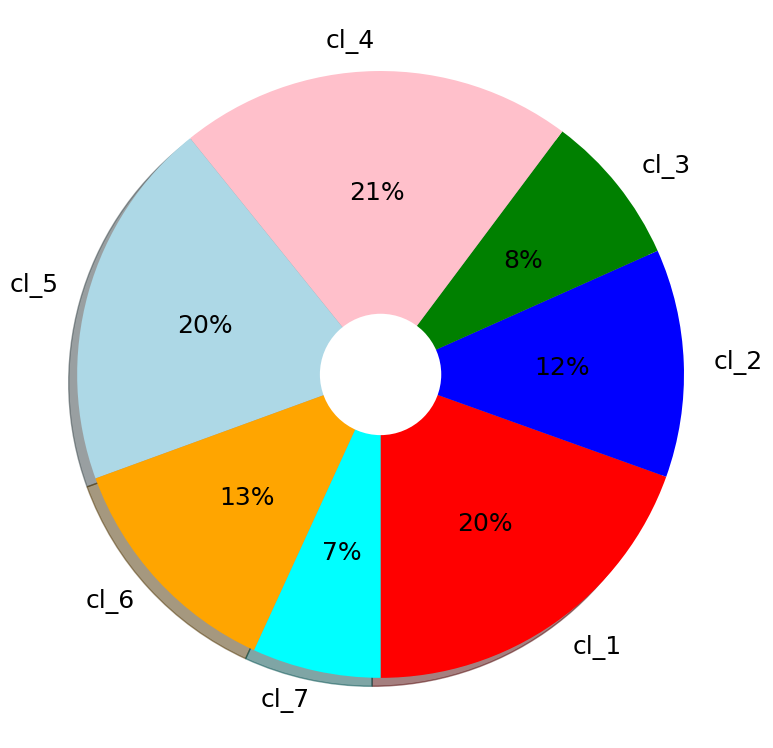



Cluster Lengths With k=:  8
Counter({0: 688, 4: 645, 7: 411, 2: 399, 5: 344, 1: 304, 3: 264, 6: 218})
SSE:  430.63769788109215
STD:  2.362645040289204
NMI:  0.008235483240310636
Rand Index:  0.00207467924313312


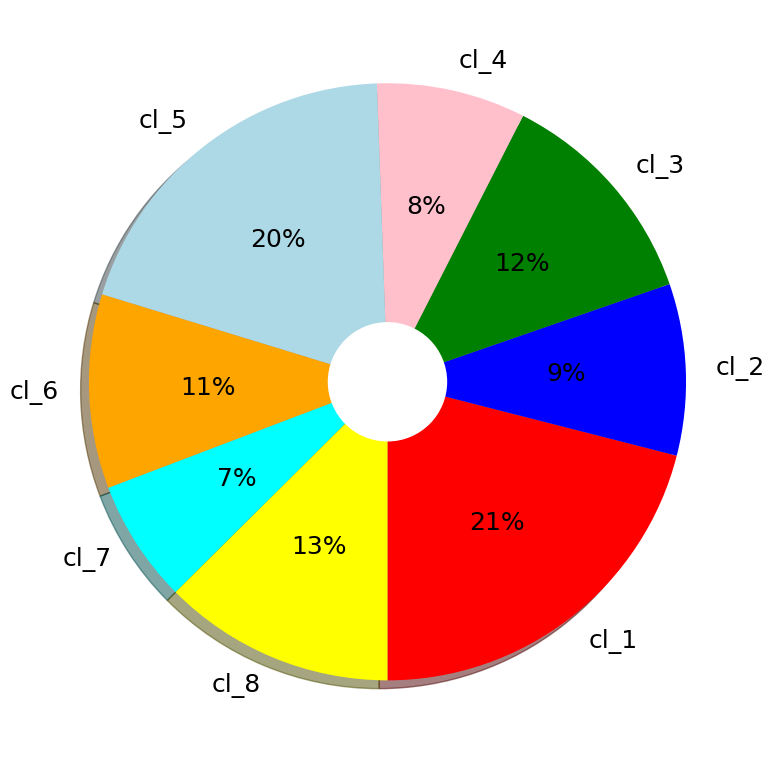



Cluster Lengths With k=:  9
Counter({0: 646, 4: 411, 8: 399, 7: 399, 5: 344, 1: 304, 2: 290, 3: 264, 6: 216})
SSE:  360.5112952245629
STD:  2.7910960291588918
NMI:  0.008046972743788412
Rand Index:  0.001325683633734072


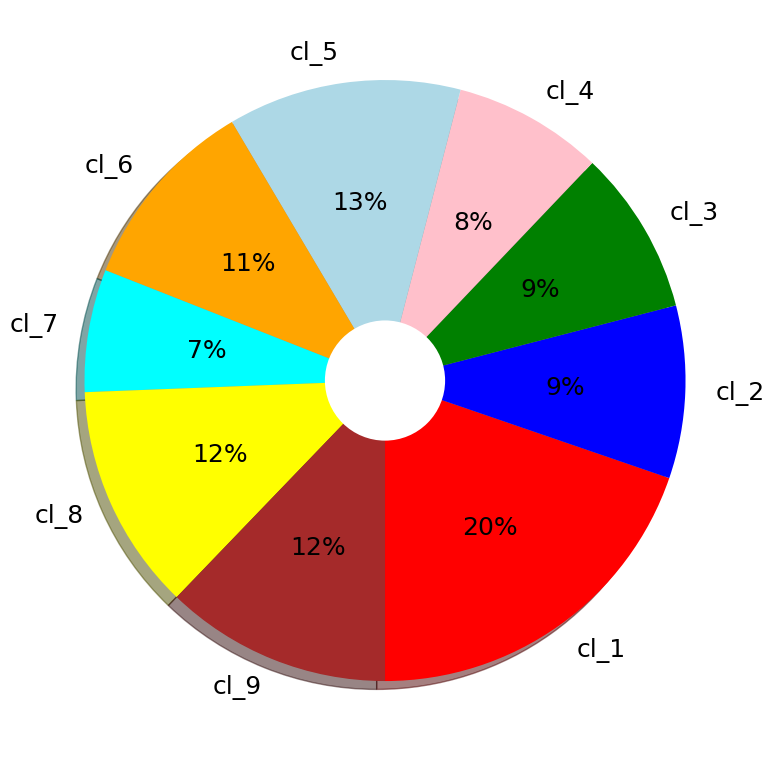



Cluster Lengths With k=:  10
Counter({1: 420, 3: 381, 8: 376, 9: 351, 7: 344, 6: 327, 2: 313, 0: 304, 4: 264, 5: 193})
SSE:  293.78046548292525
STD:  2.9678049134632727
NMI:  0.007415794394893969
Rand Index:  0.0008952639378828407


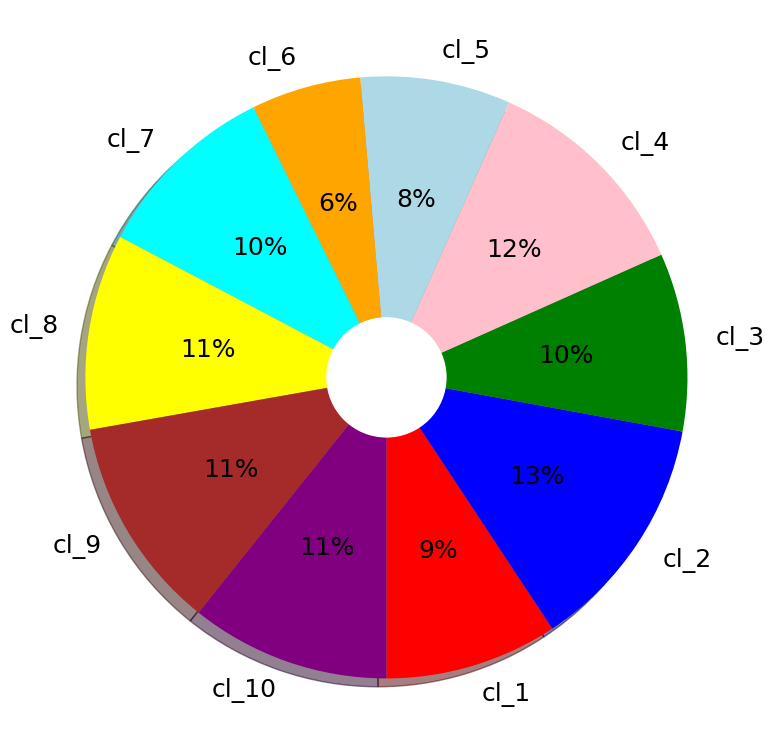



Cluster Lengths With k=:  11
Counter({1: 399, 8: 376, 2: 367, 6: 344, 9: 328, 0: 305, 4: 304, 7: 290, 3: 264, 10: 225, 5: 71})
SSE:  261.42427325593064
STD:  3.238906996516755
NMI:  0.009470318768114203
Rand Index:  0.0013900486225824195


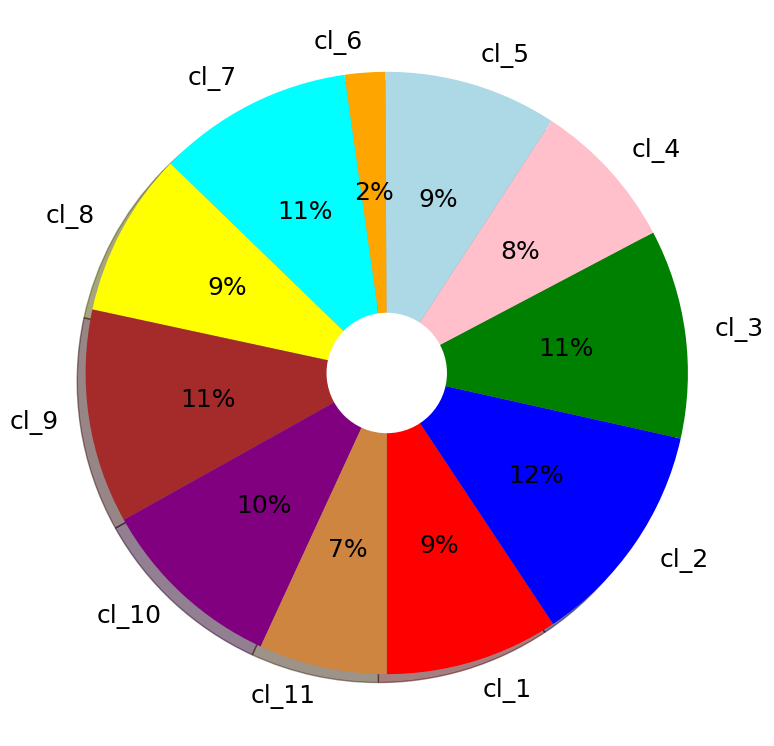



Cluster Lengths With k=:  12
Counter({8: 411, 10: 367, 7: 344, 1: 324, 4: 313, 0: 304, 5: 292, 2: 278, 3: 264, 9: 160, 11: 158, 6: 58})
SSE:  238.9220819745043
STD:  3.450024427189151
NMI:  0.01049743387079915
Rand Index:  0.0014914840256637194


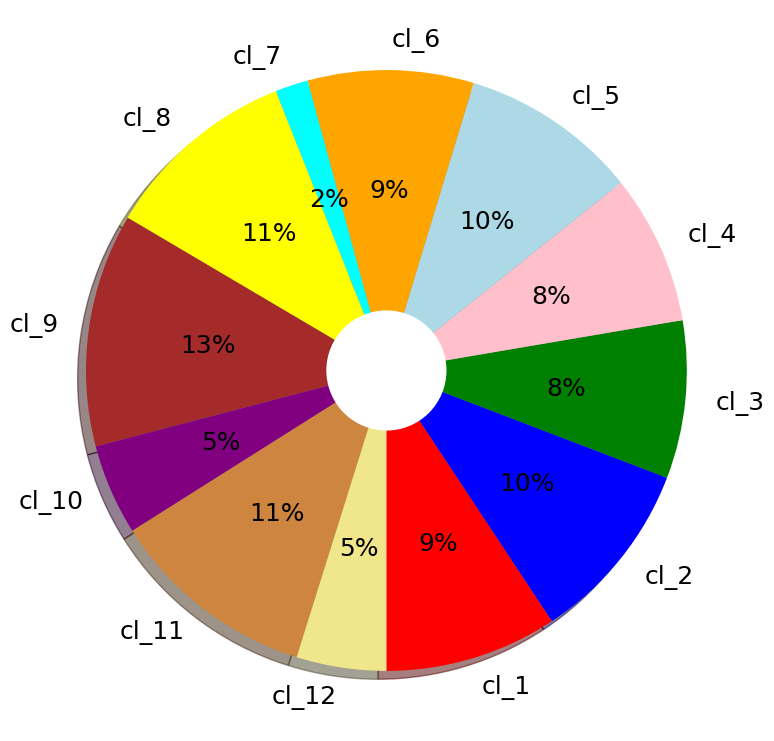

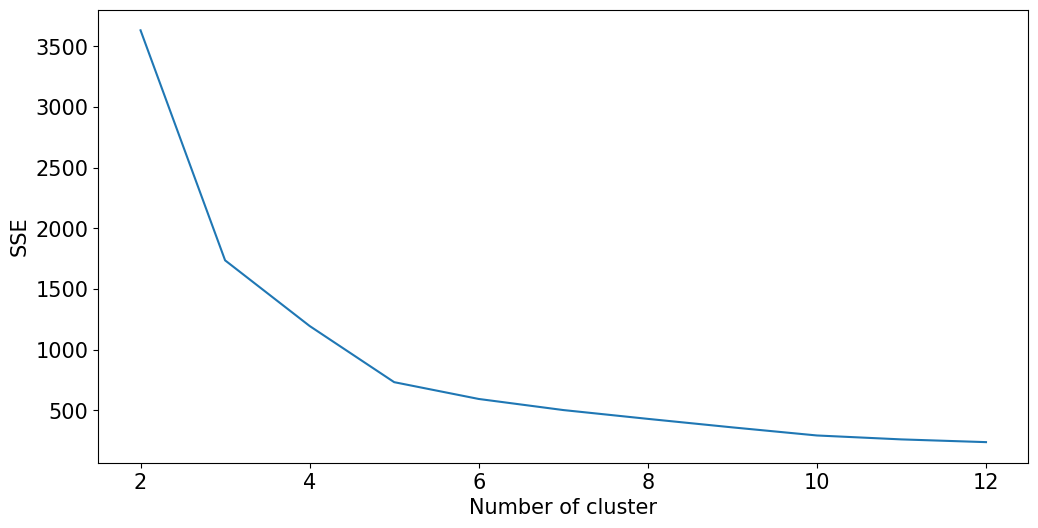

In [34]:
from collections import Counter

def instance_counts():
    sse = {}
    y = df.anomaly21
    labels = ["cl_1", "cl_2", "cl_3", "cl_4", "cl_5", "cl_6", "cl_7", "cl_8", "cl_9", "cl_10", "cl_11", "cl_12"]
    colors = ['red', 'blue', 'green', 'pink', 'lightblue', 'orange', 'cyan', 'yellow', 'brown', 'purple', 'peru', 'khaki']
    for i in range(2, 13):
        print('\n')
        print("Cluster Lengths With k=: ",i)
        
        # Creating and fitting particular cluster as a model
        kMeans = KMeans(n_clusters=i)
        kMeans.fit(data)
        predicted_Y = list(kMeans.labels_)
        sse[i] = kMeans.inertia_
        
        # Counting each of the clusters' member numbers
        print(Counter(kMeans.labels_))
        
        # Inertia: Sum of distances of samples to their closest cluster center
        print("SSE: ", kMeans.inertia_) 
        
        # Standard deviation
        print("STD: ", np.std(predicted_Y))
        
        # Please see: 
        # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.normalized_mutual_info_score.html
        print("NMI: ", normalized_mutual_info_score(y, predicted_Y))
        
        # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html
        print("Rand Index: ", adjusted_rand_score(y, predicted_Y))
        
        pie_chart(kMeans.labels_, labels[0:i], colors[0:i], i)
    
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel("Number of cluster")
    plt.ylabel("SSE")
    plt.show()

instance_counts()

## 2.2 Elliptic Envelope

Algoritma genel mantığı, belirli bir veri kümesinin etrafında hayali bir eliptik alan oluşturmaktır. Zarfın içine giren değerler normal veri olarak kabul edilir ve zarfın dışındaki değerler aykırı değer olarak döndürülür. Bu nedenle, doğal olarak, yukarıdaki diyagramdaki siyah veri noktaları, bu algoritma tarafından anomali değerler olarak tanımlanmıştır. <br>

Bizim senaryomuzda ise veri seti önemli sayılabilecek kategorilere bölünüp, ardından da her kategoriye ayrı ayrı Gauss/Eliptik Zarf uygulandı.

<img src="https://i.stack.imgur.com/Nw3dx.png" width=700 height=700 />

In [35]:
# 4 different categories defined as:
# 0: WeekEndNight
# 1: WeekEndLight
# 2: WeekDayNight
# 3: WeekDayLight

df_class0 = df.loc[df['categories'] == 0, 'value']
df_class1 = df.loc[df['categories'] == 1, 'value']
df_class2 = df.loc[df['categories'] == 2, 'value']
df_class3 = df.loc[df['categories'] == 3, 'value']

Bu algoritmanın daha efektif kullanılması adına girdi olarak verilen veri setindeki değerlerin Gauss Dağılımında olması gerekmektedir. Bunu sağlamak adına farklı kategoriler oluşturmayı düşündük, çünkü verinin ham hali normal dağılımdan çok daha uzakta olmaktaydı. Kategoriler mesai saati ve dışında, hafta içi ve hafta sonu olmak üzere 4 farklı şekilde oluşturulmuştur.

<Figure size 1200x600 with 0 Axes>

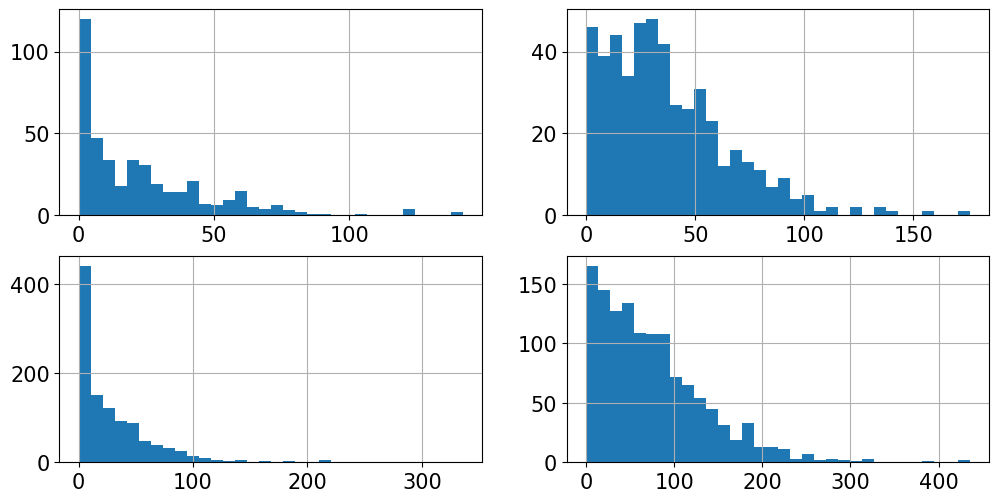

In [36]:
# plot the value repartition by categories
plt.clf()

fig, axs = plt.subplots(2,2)

df_class0.hist(ax=axs[0,0],bins=32)
df_class1.hist(ax=axs[0,1],bins=32)
df_class2.hist(ax=axs[1,0],bins=32)
df_class3.hist(ax=axs[1,1],bins=32)

plt.show()

In [37]:
# apply ellipticEnvelope(gaussian distribution) at each of the categories and train them

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class0.values.reshape(-1,1)
envelope.fit(X_train)
df_class0 = pd.DataFrame(df_class0)
df_class0['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class1.values.reshape(-1,1)
envelope.fit(X_train)
df_class1 = pd.DataFrame(df_class1)
df_class1['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class2.values.reshape(-1,1)
envelope.fit(X_train)
df_class2 = pd.DataFrame(df_class2)
df_class2['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class3.values.reshape(-1,1)
envelope.fit(X_train)
df_class3 = pd.DataFrame(df_class3)
df_class3['anomaly'] = envelope.predict(X_train)

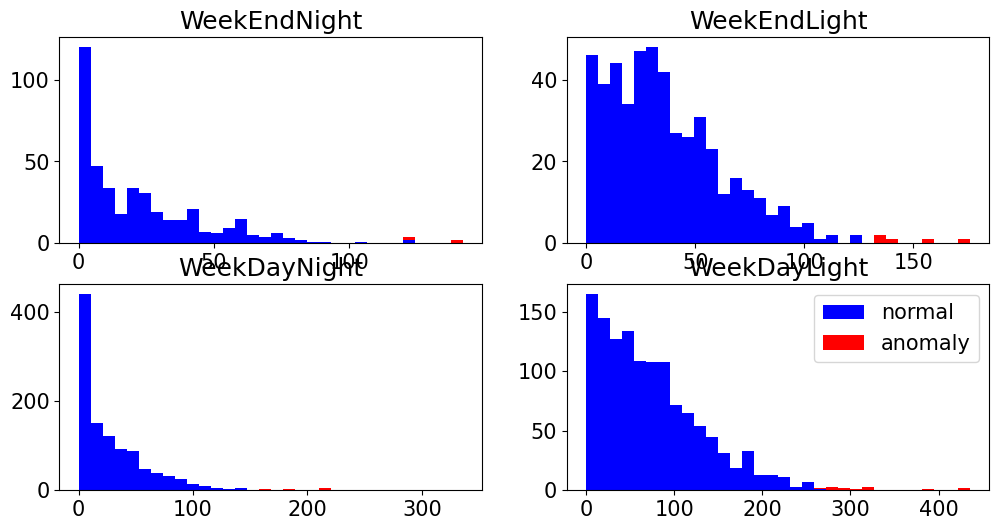

In [38]:
# Farklı kategorilerde verilerin normal ve anomali olarak sınıflandırılması
a0 = df_class0.loc[df_class0['anomaly'] == 1, 'value']
b0 = df_class0.loc[df_class0['anomaly'] == -1, 'value']

a1 = df_class1.loc[df_class1['anomaly'] == 1, 'value']
b1 = df_class1.loc[df_class1['anomaly'] == -1, 'value']

a2 = df_class2.loc[df_class2['anomaly'] == 1, 'value']
b2 = df_class2.loc[df_class2['anomaly'] == -1, 'value']

a3 = df_class3.loc[df_class3['anomaly'] == 1, 'value']
b3 = df_class3.loc[df_class3['anomaly'] == -1, 'value']

fig, axs = plt.subplots(2,2)
axs[0,0].hist([a0,b0], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0,1].hist([a1,b1], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,0].hist([a2,b2], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,1].hist([a3,b3], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0,0].set_title("WeekEndNight")
axs[0,1].set_title("WeekEndLight")
axs[1,0].set_title("WeekDayNight")
axs[1,1].set_title("WeekDayLight")

plt.legend()
plt.show()

In [39]:
# Concatenate the categories
df_class = pd.concat([df_class0, df_class1, df_class2, df_class3])

# Indicating anomaly values specified corresponding to each of the category
df['anomaly22'] = df_class['anomaly']
df['anomaly22'] = np.array(df['anomaly22'] == -1).astype(int) 

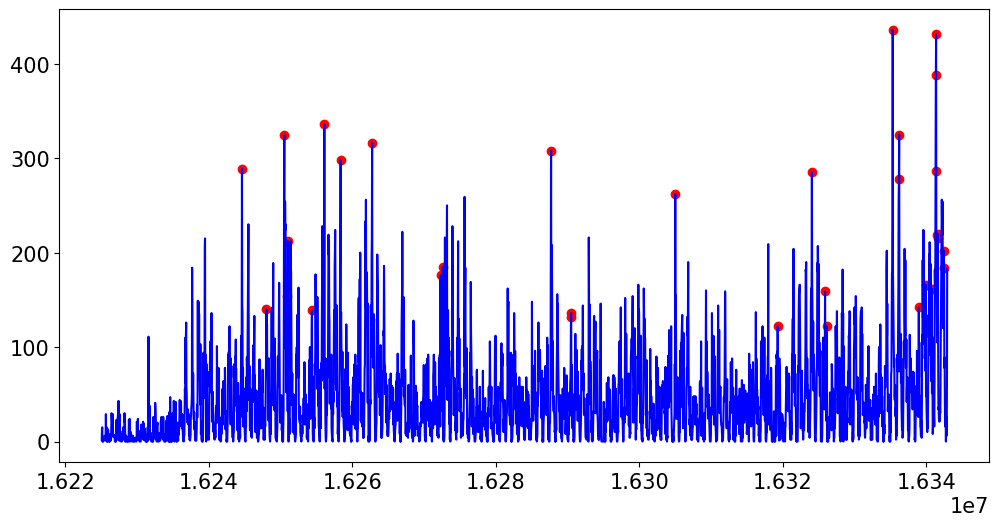

In [40]:
fig, ax = plt.subplots()

#anomaly
a = df.loc[df['anomaly22'] == 1, ('time_epoch', 'value')] 

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')

plt.show()

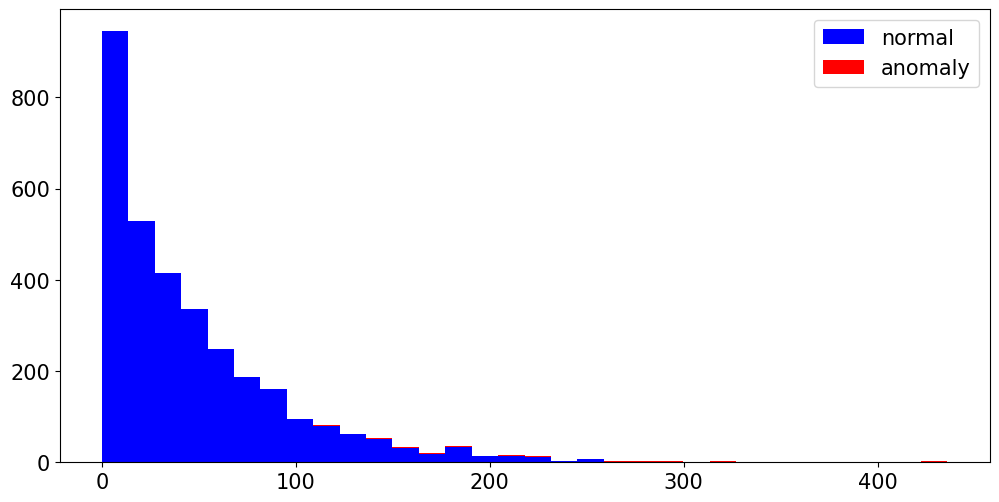

In [41]:
a = df.loc[df['anomaly22'] == 0, 'value']
b = df.loc[df['anomaly22'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])

plt.legend()
plt.show()

In [42]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(df[df['anomaly22'] == 1])

                    hour  value  hours  daylight  DayOfTheWeek  WeekDay  \
375  2021-06-23 15:00:00    289     15         1             2        1   
470  2021-06-27 14:00:00    140     14         1             6        0   
540  2021-06-30 11:00:00    324     11         1             2        1   
550  2021-06-30 20:00:00    154     20         0             2        1   
741  2021-07-01 01:00:00    212      1         0             3        1   
1342 2021-07-04 22:00:00    139     22         0             6        0   
1390 2021-07-06 22:00:00    336     22         0             1        1   
1453 2021-07-09 13:00:00    298     13         1             4        1   
855  2021-07-14 15:00:00    316     15         1             2        1   
1144 2021-07-25 16:00:00    176     16         1             6        0   
1153 2021-07-26 01:00:00    185      1         0             0        1   
1545 2021-08-12 12:00:00    308     12         1             3        1   
1625 2021-08-15 17:00:00 

In [43]:
anomaly22_df = df[df['anomaly22'] == 1].hour

# If same anomaly is detected before increase its count
# Otherwise add it to the dictionary
for index, value in anomaly22_df.items():
    if value in timestamp_dict:
        timestamp_dict[value] += 1
    else:
        timestamp_dict[value] = 1

In [44]:
for w in sorted(timestamp_dict, key=timestamp_dict.get, reverse=True):
    print(w, timestamp_dict[w])

2021-09-01 13:00:00 2
2021-09-23 14:00:00 2
2021-10-06 15:00:00 2
2021-10-07 15:00:00 2
2021-10-07 16:00:00 2
2021-10-13 13:00:00 2
2021-10-13 14:00:00 2
2021-10-13 15:00:00 2
2021-06-07 16:00:00 1
2021-06-09 11:00:00 1
2021-06-09 14:00:00 1
2021-06-30 14:00:00 1
2021-07-02 15:00:00 1
2021-07-04 09:00:00 1
2021-07-04 14:00:00 1
2021-07-04 16:00:00 1
2021-07-04 17:00:00 1
2021-07-05 14:00:00 1
2021-07-14 14:00:00 1
2021-07-14 22:00:00 1
2021-07-17 13:00:00 1
2021-07-20 14:00:00 1
2021-07-20 16:00:00 1
2021-07-21 03:00:00 1
2021-07-21 05:00:00 1
2021-07-26 12:00:00 1
2021-08-20 11:00:00 1
2021-09-20 15:00:00 1
2021-10-11 11:00:00 1
2021-10-11 14:00:00 1
2021-10-11 15:00:00 1
2021-10-11 16:00:00 1
2021-06-23 15:00:00 1
2021-06-27 14:00:00 1
2021-06-30 11:00:00 1
2021-06-30 20:00:00 1
2021-07-01 01:00:00 1
2021-07-04 22:00:00 1
2021-07-06 22:00:00 1
2021-07-09 13:00:00 1
2021-07-14 15:00:00 1
2021-07-25 16:00:00 1
2021-07-26 01:00:00 1
2021-08-12 12:00:00 1
2021-08-15 17:00:00 1
2021-08-15

## 2.3 Prophet Forecasting

Documentation: https://facebook.github.io/prophet/ <br>

Prophet, lineer olmayan trendlerin, yıllık, haftalık ve günlük mevsimsellik ve tatil etkileriyle uyumlu olduğu, toplamsal bir modele dayalı zaman serisi verilerini tahmin etmek için kullanılan bir algoritmadır. Güçlü mevsimsel etkilere ve birkaç mevsimlik geçmiş veriye sahip zaman serilerinde gerçekten iyi sonuç vermektedir. Prophet’in genel özelliklerinde, kayıp verilere ve trenddeki değişimlere karşı dayanıklılığı ve tipik olarak aykırı değerleri iyi bir şekilde ele alması sıralanmaktadır.<br>
Bizim senaryomuzda diğer algoritmalardan farklı olarak bu algoritmanın kullanım amacı, kolay uygulanabilir, hızlı ve iyi sonuçlar alabildiğinden, diğer algoritmalardan çıkan sonuçlarla karşılaştırma yapmak adına biçilmiş kaftandı.

In [ ]:
from fbprophet import Prophet

df_forecast = pd.read_csv("/home/my_commands/web_credit/log-manage/WebCredit-all-logs-hourly/deneme_credit_forecast.txt")

<img src="https://facebook.github.io/prophet/static/multiplicative_seasonality_files/multiplicative_seasonality_4_0.png" width=700 height=700 />

In [ ]:
'''
daily_seasonality: In some instances the seasonality may depend on other factors, such as a weekly 
                   seasonal pattern that is different during the summer than it is during the rest 
                   of the year, or a daily seasonal pattern that is different on weekends vs. on weekdays.
                     
seasonality_mode (additive): Meaning the effect of the seasonality is added to the trend to get the forecast

seasonality_mode (multiplicative): To explain this clearly, at above time series picture, it has a clear yearly 
                                   cycle, but the seasonality in the forecast is too large at the start of the 
                                   time series and too small at the end. In this time series, the seasonality 
                                   is not a constant additive factor as assumed by Prophet, rather it grows with 
                                   the trend. This is multiplicative seasonality.
                     
interval_width: No short explaination could be derived for this parameter. 
                Please examine: https://facebook.github.io/prophet/docs/uncertainty_intervals.html
                     
changepoint_range: Detecting changepoints of first x% of the dataset

fact: Actual data
yhat: Forecasted data
yhat upper/lower: Uncertainty interval
'''

# Başvuru sayısı değer noktalarının veri ve anomali olarak sınıflandırılması
def fit_predict_model(dataframe, interval_width = 0.99, changepoint_range = 0.8):
    
    # Train and predict with given parameters to the pre-trained model of Prophet
    # returned as dataframe object
    forecast = Prophet(daily_seasonality = False, yearly_seasonality = False,
               weekly_seasonality = False, seasonality_mode = 'multiplicative',
               interval_width = interval_width, changepoint_range = changepoint_range).fit(dataframe).predict(dataframe)
    
    # transfering actual data points to forecast dataframe under "fact" title
    forecast['fact'] = dataframe['y'].reset_index(drop = True)
    
    # Plotting
    fig = m.plot(forecast)
    a = add_changepoints_to_plot(fig.gca(), m, forecast)
    
    # return whole body of forecast dataframe object
    # which includes, fact, yhat, yhat upper/lower (prediction intervals)
    return forecast

pred = fit_predict_model(df_forecast)

In [ ]:
def detect_anomalies(forecast):
    
    # Copy only necessary data columns from forecast dataframe
    forecasted = forecast[['ds', 'trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
    
    # Initialize by assigning 0 to all of them
    forecasted['anomaly'] = 0
    # If a data point is above or below the uncertainty interval, it can be indicated as anomaly
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1
    
    # Importance: how far the dot from the upper/lower boundary
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] == 1, 'importance'] = (forecasted['fact'] - forecasted['yhat_upper']) / forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = (forecasted['yhat_lower'] - forecasted['fact']) / forecast['fact']
    
    return forecasted

pred = detect_anomalies(pred)
pred.head()

In [ ]:
pred

In [ ]:
"""
Complete and detailed visualization of trend area in the histogram plot

      fact: Gerçek verimizin histogram grafiği haline getirilmiş halini göstermektedir.

      yhat: Bu zaman serisi içerisinde trend’in nasıl değiştiğini göstermektedir.

yhat_upper: Pozitif trend olarak nitelendirebileceğimiz, normalden yüksek olarak gelen başvuru 
            sayısına bağlı trendi göstermektedir.
yhat_lower: Negatif trend olarak nitelendirebileceğimiz, normalden alçak olarak gelen başvuru 
            sayısına bağlı trendi göstermektedir.
"""
pd.plotting.register_matplotlib_converters()
pred.plot(x = 'ds', y = ['fact', 'yhat', 'yhat_upper', 'yhat_lower'])
plt.xlabel('Date')
plt.ylabel('Occurence')
plt.show()

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(pred[pred['anomaly'] == 1])

Prophet her ne kadar bize pozitif anomalileri tespit etmek ve hız konusunda avantajlar sağlasa da negatif anomalileri tespit etmekte başarısız olmuştur. Algoritmanın zayıf noktalarından sayılabilecek durum şudur ki: verimizde negatif değerler bulunmasa dahi sert düşüşler yaratabilecek 0 başvuru sayısını anlamakta güçlük çekmektedir. Yaratılan trend alanı bu konuda esneklik yaratamadığından eksik kalmaktadır.

In [ ]:
# Adding anomalies detected from prophet algorithm as column to dataframe
df['anomaly23'] = pred['anomaly']

anomaly23_df = pred[pred['anomaly'] == 1].ds
      
for index, value in anomaly23_df.items():
    if value in timestamp_dict:
        timestamp_dict[value] += 1
    else:
        timestamp_dict[value] = 1

## 2.4 Markov chains
Güzel ve sade bir anlatım: https://www.youtube.com/watch?v=EqUfuT3CC8s&ab_channel=LaneVotapka <br><br>
Bu algoritmada Markov, mevcut durum verildiğinde, gelecek durumların geçmiş durumlardan bağımsız olması anlamına gelir. Mevcut durumun açıklaması, sürecin gelecekteki evrimini etkileyecebilecek tüm bilgiyi kapsar. Gelecek durumlara belirli bir şekilde değil, olasılıksal bir süreçle ulaşılacaktır.
Her bir anda sistem belirli bir olasılık dağılımına bağlı olarak kendi durumundan başka bir duruma geçebilir veya aynı durumda kalabilir. Durumda olan değişiklikler geçiş olarak bilinir ve çeşitli durum değişmeleriyle ilişkili olasılıklar da geçiş olasılıkları olarak adlandırılır.

<img src="https://miro.medium.com/max/437/1*SUUir-VGHy2OFqbpKxwuJA.png" width=400 height=400 />

Yukarıdaki figürde “a, B ve C” olarak belirtilen şekiller birer “durumu” belirtmektedir. Aradaki olasılıklar da geçişi simgelemektedir. Sağındaki “P” ise bu olasılıkların matris yapısına dönüştürülmüş halidir. Hızlı ve efektif hesaplamalar yapmak gerektiğinden bu matris yapısı kullanılmaktadır. <br>

Bizim senaryomuzda kredi başvuru sayılarına bağlı olarak, çok düşük, düşük, ortalama, yüksek, çok yüksek olmak üzere 5 farklı durum bulunmaktadır. Başlangıçta hangi verinin “okunduğundan” bağımsız olarak tüm veriler okunduktan sonra, veriler arası dağılım olasılıkları oluşturulmuş, “çok düşük” ve “çok yüksek” durumlara nerelerden ve hangi oranlarda geçiş yapıldığını saptamak kolay olacaktır. 

In [ ]:
# transition from dataframe to transition matrix
def getTransitionMatrix (df):
	df = np.array(df)
	model = msm.estimate_markov_model(df, 1)
	return model.transition_matrix

# detect whether a particular instance is an anomaly or not
# by comparing them with their associated window boundaries
def markovAnomaly(df, windows_size, threshold):
    transition_matrix = getTransitionMatrix(df)
    real_threshold = threshold**windows_size
    df_anomaly = []
    for j in range(0, len(df)):
        if (j < windows_size):
            df_anomaly.append(0)
        else:
            sequence = df[j-windows_size:j]
            sequence = sequence.reset_index(drop=True)
            df_anomaly.append(anomalyElement(sequence, real_threshold, transition_matrix))
    return df_anomaly

# if the sequence is an anomaly considering a threshold
def anomalyElement(sequence, threshold, transition_matrix):
    if (sucessScore(sequence, transition_matrix) > threshold):
        return 0
    else:
        return 1

# the success probability of the whole sequence
def sucessScore(sequence, transition_matrix):
    proba = 0
    for i in range(1,len(sequence)):
        if(i == 1):
            proba = successProbabilityMetric(sequence[i-1], sequence[i], transition_matrix)
        else:
            proba = proba*successProbabilityMetric(sequence[i-1], sequence[i], transition_matrix)
    return proba

# the success probability of the state change
def successProbabilityMetric(state1, state2, transition_matrix):
    proba = 0
    for k in range(0, len(transition_matrix)):
        if (k != (state2 - 1)):
            proba += transition_matrix[state1-1][k]
    return 1-proba

In [ ]:
# definition of different states ranging from one value to another

x1 =  (df['value'] <= 17).astype(int)
x2 = ((df['value']  > 17) & (df['value'] <= 30)).astype(int)
x3 = ((df['value']  > 30) & (df['value'] <= 43)).astype(int)
x4 = ((df['value']  > 43) & (df['value'] <= 100)).astype(int)
x5 =  (df['value'] > 100).astype(int)

# Adding the instances of data from each series with each other
# to have concenated resulting series object
df_mm = x1 + 2*x2 + 3*x3 + 4*x4 + 5*x5

# getting the anomaly labels from the given series 
# sequence of 5 values, anomaly if less than 20% probability)
df_anomaly = markovAnomaly(df_mm, 5, 0.20)
df_anomaly = pd.Series(df_anomaly)
print(df_anomaly.value_counts())

In [ ]:
# add the data to the main 
df['anomaly24'] = df_anomaly

# visualisation of anomaly throughout time 
fig, ax = plt.subplots()

#anomaly
a = df.loc[df['anomaly24'] == 1, ('time_epoch', 'value')] 

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')

plt.show()

Yukarıdaki figürde ilk denemelerimizden elde ettiğimiz anomali tespit grafiği aktarılmıştır. Bu algoritmanın diğerlerinden farklı olarak umut vadeden tarafı, eğer güzel bir şekilde durum dağılımlarını ayarlayıp büyük verilerle çalışılırsa, durumlar arası geçiş olasılıkları olabildiğince optimal düzene oturmuş olacaktır. Bunun sonucu olarak da istenilen trend altı ve üstü kalan anomalileri yakalamak mümkün hale gelecektir. Henüz iyi sonuçlar alamamış olsak dahi üzerine kafa yormanın ve geliştirmenin mantıklı olacağını düşündüğümüz bir algoritmadır.

In [ ]:
# visualisation of anomaly with value repartition 
a = df.loc[df['anomaly24'] == 0, 'value']
b = df.loc[df['anomaly24'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])

plt.legend()
plt.show()

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(df[df['anomaly24'] == 1])

In [ ]:
anomaly24_df = df[df['anomaly24'] == 1].hour
      
for index, value in anomaly24_df.items():
    if value in timestamp_dict:
        timestamp_dict[value] += 1
    else:
        timestamp_dict[value] = 1

In [ ]:
for w in sorted(timestamp_dict, key=timestamp_dict.get, reverse=True):
    print(w, timestamp_dict[w])

## 2.5 Isolation Forest
Anomali tespiti için kullanılan en yaygın teknikler, “normal” olan verilerin profilini oluşturulup, veri setinde normal profile uymayan örneklerin anomali olarak rapor edilmesi prensibine dayanmaktadır. Isolation Forest, bunlardan farklı bir yaklaşım kullanarak, normal örneklerden oluşan bir model oluşturmaya çalışmak yerine, veri kümesindeki anormal noktaları izole etmeye uğraşmaktadır. <br><br>
Bu yaklaşımın birkaç temel avantajı şöyle sıralanabilir: profil tabanlı metodlarda kullanılması mümkün olmayan örnekleme (sampling) tekniklerinden yararlanabilmektedir. Ayrıca, düşük bellek gereksinimi ile çok hızlı sonuçlar alabilmek mümkündür.

<img src="https://upload.wikimedia.org/wikipedia/commons/f/ff/Isolating_an_Anomalous_Point.png" width=400 height=400 /> <br>
&emsp;&emsp; *2 boyutlu veri kümesinde algoritmanın implementasyonunun görselleştirilmesi*

Algoritmanın temel mantığı, “anomali” olarak nitelendirilebilecek verilerin “normal” verilere kıyasla daha kolay izole hale getirebileceğini savunmaktadır. <br>
Bir veri noktasını izole etmek için algoritma yinelemeli olarak çalışarak, ilk olarak rastgele bir nitelik seçer. Bu niteliğe ait minimum ve maksimum değerler arasında rastgele bir değer seçerek bu örnek kümesi içerisinde bölümler oluşturur. <br>
Yukarıdaki figürde de görülebileceği üzere oluşan alanlar üzerinde bazı veriler ana kümeden farklı pencereye düşerek izole hale getirilmiştir.

In [45]:
# Take useful feature and standardize them
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)

# converting back to dataframe format
data = pd.DataFrame(np_scaled)

# Train isolation forest model
model =  IsolationForest(contamination = outliers_fraction)
model.fit(data)

# add the data to the main  
df['anomaly25'] = pd.Series(model.predict(data))
df['anomaly25'] = df['anomaly25'].map( {1: 0, -1: 1} )
print(df['anomaly25'].value_counts())

0    3240
1      33
Name: anomaly25, dtype: int64


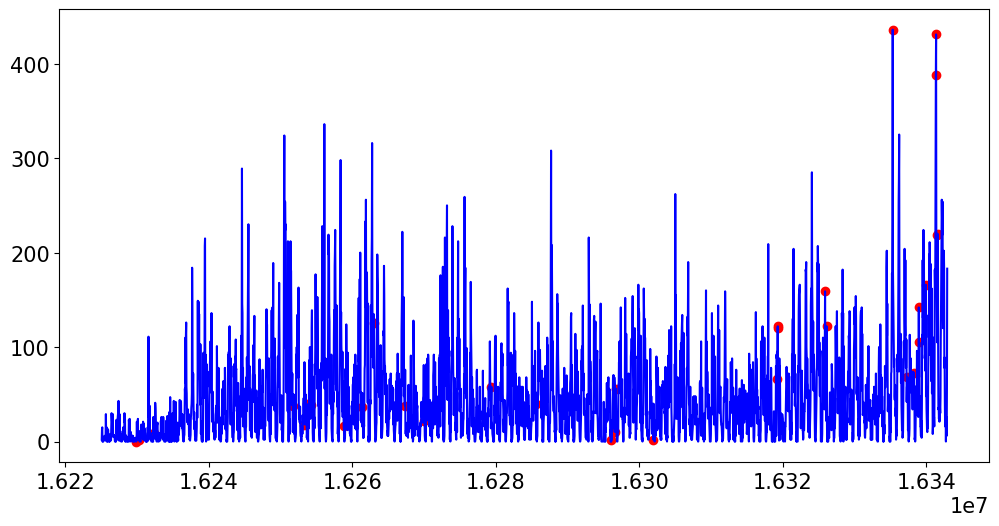

In [46]:
# visualisation of anomaly throughout time 
fig, ax = plt.subplots()

#anomaly
a = df.loc[df['anomaly25'] == 1, ['time_epoch', 'value']] 

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')

plt.show()

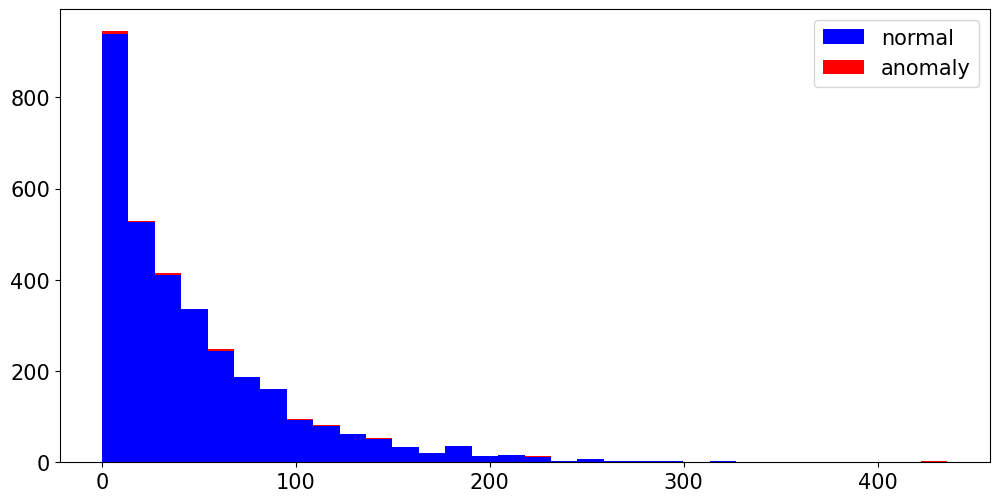

In [47]:
# visualisation of anomaly with value repartition 
a = df.loc[df['anomaly25'] == 0, 'value']
b = df.loc[df['anomaly25'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label = ['normal', 'anomaly'])

plt.legend()
plt.show()

In [48]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(df[df['anomaly25'] == 1])

                    hour  value  hours  daylight  DayOfTheWeek  WeekDay  \
638  2021-06-06 14:00:00      0     14         1             6        0   
647  2021-06-06 23:00:00      2     23         0             6        0   
707  2021-06-09 11:00:00      9     11         1             2        1   
814  2021-07-01 22:00:00     38     22         0             3        1   
1312 2021-07-03 16:00:00     18     16         1             5        0   
1321 2021-07-04 01:00:00     40      1         0             6        0   
1337 2021-07-04 17:00:00     39     17         1             6        0   
721  2021-07-10 01:00:00     16      1         0             5        0   
813  2021-07-12 23:00:00     37     23         0             0        1   
862  2021-07-14 22:00:00    125     22         0             2        1   
982  2021-07-19 22:00:00     38     22         0             0        1   
1080 2021-07-23 00:00:00     22      0         0             4        1   
1817 2021-08-02 21:00:00 

In [49]:
anomaly25_df = df[df['anomaly25'] == 1].hour
      
for index, value in anomaly25_df.items():
    if value in timestamp_dict:
        timestamp_dict[value] += 1
    else:
        timestamp_dict[value] = 1

In [50]:
for w in sorted(timestamp_dict, key=timestamp_dict.get, reverse=True):
    print(w, timestamp_dict[w])

2021-10-06 15:00:00 3
2021-10-13 14:00:00 3
2021-10-13 15:00:00 3
2021-06-09 11:00:00 2
2021-07-04 17:00:00 2
2021-07-14 22:00:00 2
2021-09-01 13:00:00 2
2021-09-23 14:00:00 2
2021-10-07 15:00:00 2
2021-10-07 16:00:00 2
2021-10-13 13:00:00 2
2021-09-18 02:00:00 2
2021-09-25 17:00:00 2
2021-09-25 23:00:00 2
2021-10-10 20:00:00 2
2021-10-11 23:00:00 2
2021-10-13 20:00:00 2
2021-10-13 21:00:00 2
2021-06-07 16:00:00 1
2021-06-09 14:00:00 1
2021-06-30 14:00:00 1
2021-07-02 15:00:00 1
2021-07-04 09:00:00 1
2021-07-04 14:00:00 1
2021-07-04 16:00:00 1
2021-07-05 14:00:00 1
2021-07-14 14:00:00 1
2021-07-17 13:00:00 1
2021-07-20 14:00:00 1
2021-07-20 16:00:00 1
2021-07-21 03:00:00 1
2021-07-21 05:00:00 1
2021-07-26 12:00:00 1
2021-08-20 11:00:00 1
2021-09-20 15:00:00 1
2021-10-11 11:00:00 1
2021-10-11 14:00:00 1
2021-10-11 15:00:00 1
2021-10-11 16:00:00 1
2021-06-23 15:00:00 1
2021-06-27 14:00:00 1
2021-06-30 11:00:00 1
2021-06-30 20:00:00 1
2021-07-01 01:00:00 1
2021-07-04 22:00:00 1
2021-07-06

## 2.6 Support Vector Machine (SVM)
Support Vector Machines, sınıflandırma, regresyon ve anomali tespiti gibi amaçlar için yaygın olarak kullanılan bir algoritmadır. Algoritmanın amacı, bu senaryoda normal ve anomali olarak ikiye ayırdığımız sınıflandırma görevinde, bu iki sınıfı en iyi ayıracak hiper düzlemi bulmaktır. Fakat, bu öyle bir düzlem olmalıdır ki, düzleme her iki sınıftan da en yakın olan noktalar arası uzaklık maksimize edilmiş olsun. 

Aşağıdaki figürde belirtilen kesikli siyah çizgiler support vektörlerine, ortadaki siyah kalın çizgi ise bu iki sınıfı ayıran hiper düzleme karşılık gelmektedir. Bir kez optimal bir hiper düzlem bulunduktan sonra yeni gelecek bir örneğin sınıflandırmasını ve anomali olup olmadığını tespit etmek gayet mümkün olacaktır. 

<img src = "https://static.wixstatic.com/media/8f929f_7ecacdcf69d2450087cb4a898ef90837~mv2.png" width = 400 height = 400 />

Bizim özellikle bu algoritmadan faydalanmak istememizin sebeplerinin başında, veri setimiz ileri zamanlarda kompleks hale gelmeye başladığında dahi verimli çalışacak algoritmalara ihtiyaç duyacağımızı düşünmemiz olmuştur. Çünkü yukarıda verilen örnek her ne kadar 2 boyut düzlemde olsa da 3 ve üzeri boyutlarda da verimli ve hızlı çalışabilmektedir. Ayrıca sadece lineer modellerle kalmayıp, polinom, üstel ve sigmoid fonksiyonlar için de efektif hiper düzlemler bulabilmektedir.

In [51]:
# Take useful feature and standardize them 
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)

# Train support vector machine model 
# nu: An upper bound on the fraction of training errors and a lower bound of the fraction of support vectors.
model =  OneClassSVM(nu = 0.95 * outliers_fraction)
data = pd.DataFrame(np_scaled)
model.fit(data)

# add the data to the main  
df['anomaly26'] = pd.Series(model.predict(data))
df['anomaly26'] = df['anomaly26'].map( {1: 0, -1: 1} )
print(df['anomaly26'].value_counts())

0    3236
1      37
Name: anomaly26, dtype: int64


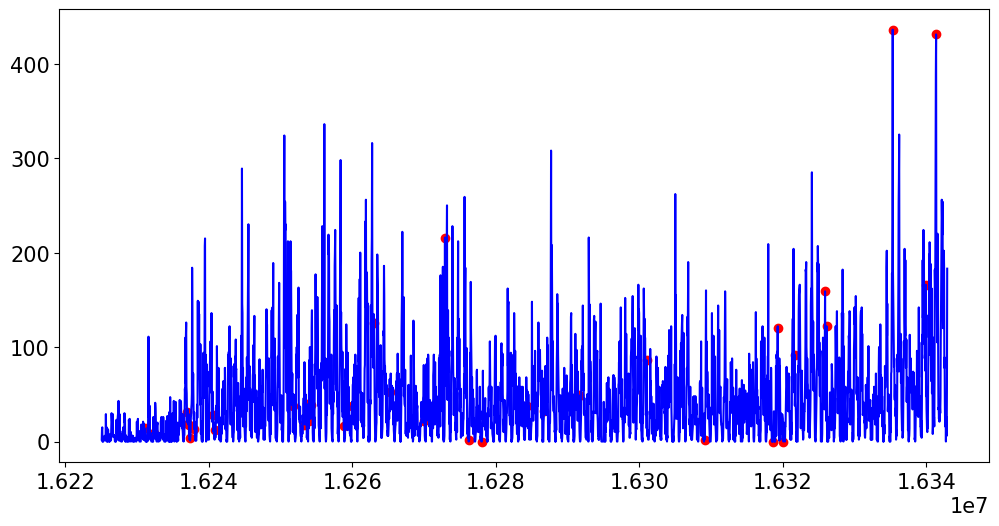

In [52]:
# visualisation of anomaly throughout time 
fig, ax = plt.subplots()

#anomaly
a = df.loc[df['anomaly26'] == 1, ['time_epoch', 'value']] 

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

Yukarıdaki figürde özellikle belirtmek istediğimiz kısım şu olabilir: bu 6 algoritma birbirleriyle karşılaştırıldığında her birinin kendi arasında farklı avantajları ve dezavantajları ortaya çıkmaktadır. Fakat bunların arasında hem daha esnek yapıya sahip hem de gelişmeye çok açık olan algoritmalar bulunmaktadır. Öznel bir değerlendirme yaptığımızda bunlardan birinin de SVM algoritması olduğunu görmekteyiz. Hem trend altı kalan hem de üstünde kalan anormallikleri belirlemekte iyi iş çıkarmaktadır. Farklı kernel fonksiyonları ve parametrelerle olabildiğince optimal çözümler bulmaya çalışacağız.

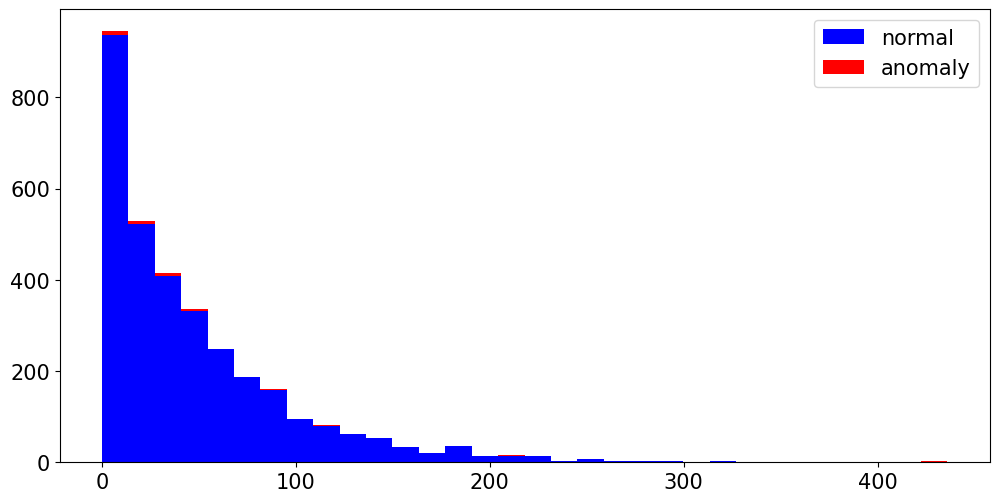

In [53]:
# visualisation of anomaly with value repartition 
a = df.loc[df['anomaly26'] == 0, 'value']
b = df.loc[df['anomaly26'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

In [54]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(df[df['anomaly26'] == 1])

                    hour  value  hours  daylight  DayOfTheWeek  WeekDay  \
670  2021-06-07 22:00:00     14     22         0             0        1   
707  2021-06-09 11:00:00      9     11         1             2        1   
139  2021-06-14 19:00:00     31     19         1             0        1   
143  2021-06-14 23:00:00     19     23         0             0        1   
144  2021-06-15 00:00:00     18      0         0             1        1   
151  2021-06-15 07:00:00      4      7         1             1        1   
167  2021-06-15 23:00:00     13     23         0             1        1   
240  2021-06-19 00:00:00     28      0         0             5        0   
247  2021-06-19 07:00:00     12      7         1             5        0   
814  2021-07-01 22:00:00     38     22         0             3        1   
1312 2021-07-03 16:00:00     18     16         1             5        0   
1321 2021-07-04 01:00:00     40      1         0             6        0   
1329 2021-07-04 09:00:00 

In [55]:
anomaly26_df = df[df['anomaly26'] == 1].hour
      
for index, value in anomaly26_df.items():
    if value in timestamp_dict:
        timestamp_dict[value] += 1
    else:
        timestamp_dict[value] = 1

In [56]:
for w in sorted(timestamp_dict, key=timestamp_dict.get, reverse=True):
    print(w, timestamp_dict[w])

2021-10-06 15:00:00 4
2021-10-13 15:00:00 4
2021-06-09 11:00:00 3
2021-07-04 17:00:00 3
2021-07-14 22:00:00 3
2021-10-13 14:00:00 3
2021-09-25 17:00:00 3
2021-09-25 23:00:00 3
2021-10-11 23:00:00 3
2021-07-04 09:00:00 2
2021-07-17 13:00:00 2
2021-09-01 13:00:00 2
2021-09-23 14:00:00 2
2021-10-07 15:00:00 2
2021-10-07 16:00:00 2
2021-10-13 13:00:00 2
2021-09-18 02:00:00 2
2021-10-10 20:00:00 2
2021-10-13 20:00:00 2
2021-10-13 21:00:00 2
2021-07-01 22:00:00 2
2021-07-03 16:00:00 2
2021-07-04 01:00:00 2
2021-07-10 01:00:00 2
2021-07-23 00:00:00 2
2021-09-18 01:00:00 2
2021-06-07 16:00:00 1
2021-06-09 14:00:00 1
2021-06-30 14:00:00 1
2021-07-02 15:00:00 1
2021-07-04 14:00:00 1
2021-07-04 16:00:00 1
2021-07-05 14:00:00 1
2021-07-14 14:00:00 1
2021-07-20 14:00:00 1
2021-07-20 16:00:00 1
2021-07-21 03:00:00 1
2021-07-21 05:00:00 1
2021-07-26 12:00:00 1
2021-08-20 11:00:00 1
2021-09-20 15:00:00 1
2021-10-11 11:00:00 1
2021-10-11 14:00:00 1
2021-10-11 15:00:00 1
2021-10-11 16:00:00 1
2021-06-23

## 2.7 LSTM
LSTM is well-suited to classify, process and predict time series given time lags of unknown duration. LSTM learn to recognize sequence in the data and then make prediction based on the previous sequence. We consider an anomaly when the next data points are distant from the prediction.

In [8]:
import tensorflow as tf
from tensorflow.python.keras.layers import Input, Dense,Activation, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential, model_from_json
import time 
import sys

In [9]:
# select and standardize data
data_n = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data_n)
data_n = pd.DataFrame(np_scaled)

# unroll_length: learn from 50 previous values
# prediction_time: predict just the 1 next value.
prediction_time = 1 
testdatasize = 1000
unroll_length = 50
testdatacut = testdatasize + unroll_length  + 1

# preparation of train data
x_train = data_n[0:-prediction_time-testdatacut].to_numpy()
y_train = data_n[prediction_time:-testdatacut  ][0].to_numpy()

# preparation of test data
x_test = data_n[0-testdatacut:-prediction_time].to_numpy()
y_test = data_n[prediction_time-testdatacut:  ][0].to_numpy()

In [10]:
# create sequence of x previous data points from the given array of data
def unroll(data, sequence_length = 24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

# adapt the datasets for the sequence data shape
x_train = unroll(x_train, unroll_length)
x_test  = unroll(x_test, unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]

# Shapes displayed
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (2171, 50, 5)
y_train (2171,)
x_test (1000, 50, 5)
y_test (1000,)


In [11]:
# Build the model with given specifications
model = Sequential()
model.add(LSTM(units=100, input_shape=(x_train.shape[1], 5), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print('compilation time : {}'.format(time.time() - start))
print(model.summary())

compilation time : 0.0030040740966796875
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 100)           42400     
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 50, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 100)               0         
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, 1)                 101       
_________________________________________________________________
module_wrapper_3 (ModuleWrap (None, 1)                 0         
Total params: 122,901
Trainable params: 122,901
Non-trainable params: 0
_________

In [12]:
# Train the model with given specifications
history = model.fit( 
    x_train,
    y_train,
    batch_size = 3028,
    epochs = 30,
    validation_split = 0.1)

Epoch 1/30
1/1 [==============================] - 3s 3s/step - loss: 0.9543 - val_loss: 0.5462
Epoch 2/30
1/1 [==============================] - 1s 901ms/step - loss: 0.8383 - val_loss: 0.4160
Epoch 3/30
1/1 [==============================] - 1s 875ms/step - loss: 0.7305 - val_loss: 0.4019
Epoch 4/30
1/1 [==============================] - 1s 858ms/step - loss: 0.6369 - val_loss: 0.3836
Epoch 5/30
1/1 [==============================] - 1s 849ms/step - loss: 0.5795 - val_loss: 0.4087
Epoch 6/30
1/1 [==============================] - 1s 879ms/step - loss: 0.5583 - val_loss: 0.4115
Epoch 7/30
1/1 [==============================] - 1s 851ms/step - loss: 0.5802 - val_loss: 0.4236
Epoch 8/30
1/1 [==============================] - 1s 887ms/step - loss: 0.5590 - val_loss: 0.3518
Epoch 9/30
1/1 [==============================] - 1s 849ms/step - loss: 0.5377 - val_loss: 0.3617
Epoch 10/30
1/1 [==============================] - 1s 857ms/step - loss: 0.5058 - val_loss: 0.3367
Epoch 11/30
1/1 [=====

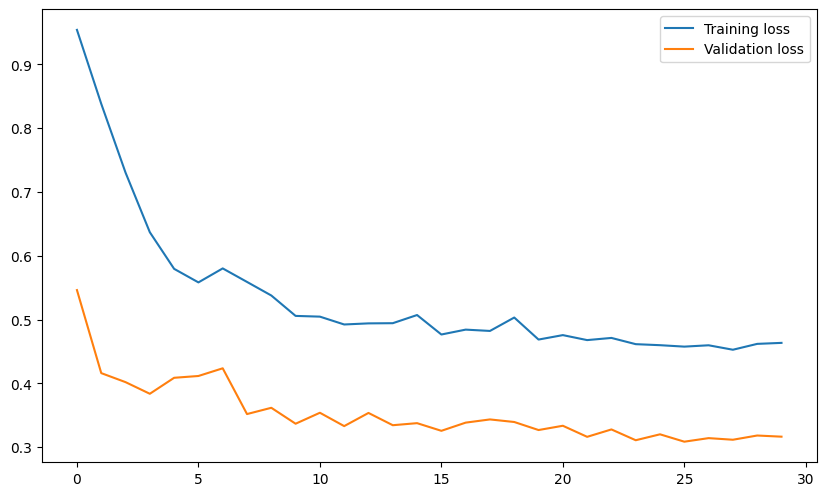

In [13]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();
plt.show()

In [14]:
model.evaluate(x_test, y_test)

32/32 [==============================] - 0s 14ms/step - loss: 0.5838


0.5837675929069519

In [18]:
# create the list of difference between prediction and test data
loaded_model = model
diff=[]
ratio=[]
p = loaded_model.predict(x_test)

for el in range(len(y_test)):
    pr = p[el][0]
    ratio.append((y_test[el]/pr)-1)
    diff.append(abs(y_test[el]- pr))

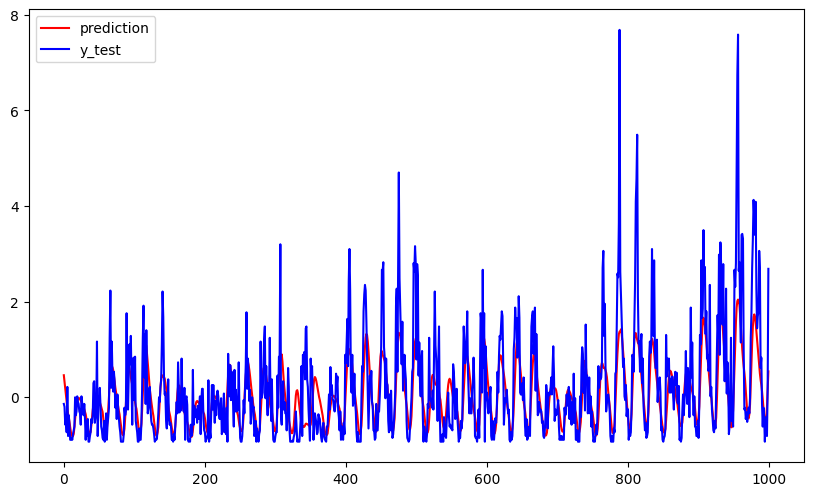

In [19]:
# plot the prediction and the reality (for the test data)
fig, axs = plt.subplots()
axs.plot(p,color='red', label='prediction')
axs.plot(y_test,color='blue', label='y_test')
plt.legend(loc='upper left')
plt.show()

In [20]:
# select the most distant prediction/reality data points as anomalies
diff = pd.Series(diff)
number_of_outliers = int(outliers_fraction*len(diff))
threshold = diff.nlargest(number_of_outliers).min()

# data with anomaly label (test data part)
test = (diff >= threshold).astype(int)

# the training data part where we didn't predict anything (overfitting possible): no anomaly
complement = pd.Series(0, index=np.arange(len(data_n)-testdatasize))

# add the data to the main
df['anomaly27'] = complement.append(test, ignore_index='True')
print(df['anomaly27'].value_counts())

0    3263
1      10
Name: anomaly27, dtype: int64


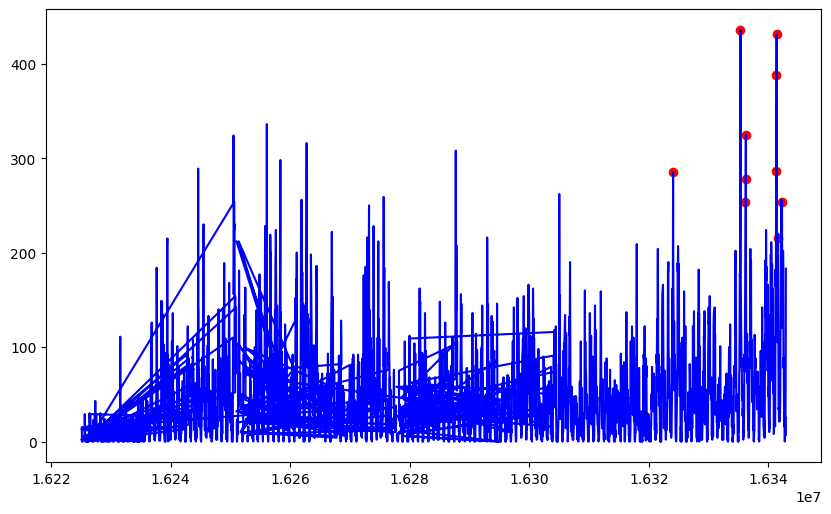

In [21]:
# visualisation of anomaly throughout time 
fig, ax = plt.subplots()

#anomaly
a = df.loc[df['anomaly27'] == 1, ['time_epoch', 'value']] 

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

No handles with labels found to put in legend.


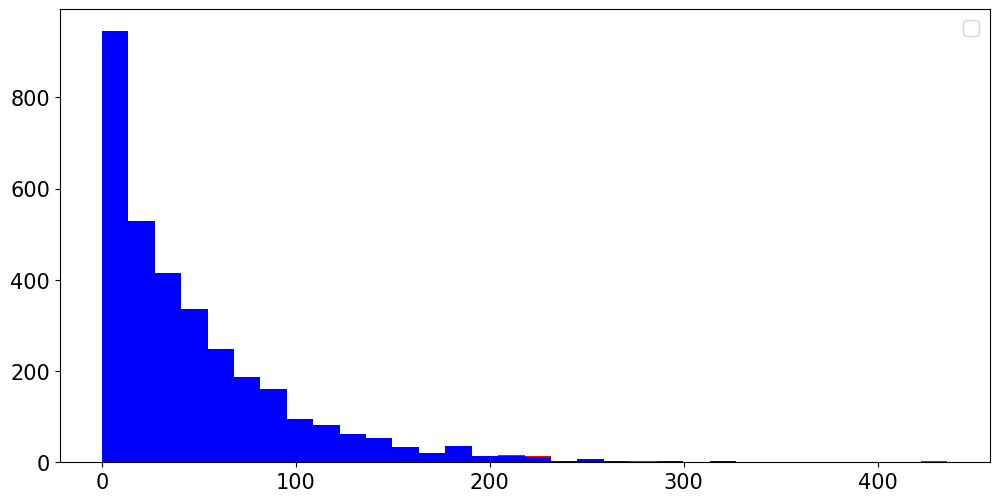

In [72]:
# visualisation of anomaly with value repartition 
a = df.loc[df['anomaly27'] == 0, 'value']
b = df.loc[df['anomaly27'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.legend()
plt.show()

In [73]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(df[df['anomaly27'] == 1])

                    hour  value  hours  daylight  DayOfTheWeek  WeekDay  \
2748 2021-09-23 14:00:00    285     14         1             3        1   
3038 2021-10-05 16:00:00    202     16         1             1        1   
3061 2021-10-06 15:00:00    436     15         1             2        1   
3085 2021-10-07 15:00:00    278     15         1             3        1   
3086 2021-10-07 16:00:00    325     16         1             3        1   
3227 2021-10-13 13:00:00    286     13         1             2        1   
3228 2021-10-13 14:00:00    388     14         1             2        1   
3229 2021-10-13 15:00:00    431     15         1             2        1   
3235 2021-10-13 21:00:00    220     21         0             2        1   
3236 2021-10-13 22:00:00    215     22         0             2        1   

      time_epoch  categories  cluster  principal_feature1  principal_feature2  \
2748    16324056           3        0            1.861649            2.127747   
3038    1633

In [74]:
anomaly27_df = df[df['anomaly27'] == 1].hour
      
for index, value in anomaly27_df.items():
    if value in timestamp_dict:
        timestamp_dict[value] += 1
    else:
        timestamp_dict[value] = 1

# 3. Result analysis

## 3.1 most common timestamps

In [ ]:
for w in sorted(timestamp_dict, key=timestamp_dict.get, reverse=True):
    print(w, timestamp_dict[w])

## 3.2 most common days

In [ ]:
date_list = []

# collecting only dates
for key, value in timestamp_dict.items():
    current_key = key.strftime('%Y-%m-%d')
    date_list.append(current_key)

In [ ]:
from collections import Counter

Counter(date_list).most_common()

## 3.3 Feature analysis after adding the feature 'isHoliday'
Bu noktada aslında amaçladığımız şey şudur: önceki yapay eklenen feature'larla beraber "isHoliday"'ı da eklememizle beraber feature'lar arası korelasyon nasıl olacaktır, bunu görmeye çalışıyoruz. 

In [ ]:
# Hazır kütüphanelerde Türkiye'deki resmi ve dini bayramlar tam olarak listelenmediğinden
# kendi elimle belirlediğim indexlere verdim.
holiday1 = list(range(1056, 1080))
holiday2 = list(range(1152, 1272))

for i in range(1584):
    if i in holiday1 or i in holiday2:
        df.at[i, 'isHoliday'] = 1
    else:
        df.at[i, 'isHoliday'] = 0

In [ ]:
df.head()

In [ ]:
df.describe()

In [ ]:
df.info()

In [ ]:
# Data Exploration

plt.figure(figsize=(15,15))
i = 0

feature_list = ["hour", "value", "hours", "daylight", "DayOfTheWeek", "WeekDay", "time_epoch",
                "categories", "cluster", "principal_feature1", "principal_feature2", "isHoliday",
                "anomaly21", "anomaly22", "anomaly24", "anomaly25", "anomaly26", "anomaly27"]

for col in feature_list:
    i = i + 1
    plt.subplot(5,4,i)
    sns.histplot(data=df[col], legend=True)

plt.show()

## 3.4 Information Gain

Information gain calculates the reduction in entropy from the transformation of a dataset. It can be used for feature selection by evaluating the Information gain of each variable in the context of the target variable.

In [ ]:
X_infog = df.drop(["anomaly21", "anomaly22", "anomaly23", "anomaly24", "anomaly25", "anomaly26", "anomaly27"], 1)
X_infog = X_infog.drop('hour', 1)
y_infog_21 = df.anomaly21
y_infog_22 = df.anomaly22
y_infog_24 = df.anomaly24
y_infog_25 = df.anomaly25
y_infog_26 = df.anomaly26
y_infog_27 = df.anomaly27

### 3.4.1 Information Gain on K-means

In [ ]:
from sklearn.feature_selection import mutual_info_classif

X_infog = X_infog.astype('float32')
y_infog_21 = y_infog_21.astype('float32')
importances_21 = mutual_info_classif(X_infog, y_infog_21, discrete_features = True)

importances_21

In [ ]:
feat_importances = pd.Series(importances_21, X_infog.columns)
feat_importances.plot(kind='barh',color='teal')
plt.show()

### 3.4.2 Information Gain on Elliptic Envelope

In [ ]:
from sklearn.feature_selection import mutual_info_classif

X_infog = X_infog.astype('float32')
y_infog_22 = y_infog_22.astype('float32')
importances_22 = mutual_info_classif(X_infog, y_infog_22, discrete_features = True)

importances_22

In [ ]:
feat_importances = pd.Series(importances_22, X_infog.columns)
feat_importances.plot(kind = 'barh',color='teal')
plt.show()

### 3.4.3 Information Gain on Markov Chains

In [ ]:
from sklearn.feature_selection import mutual_info_classif

X_infog = X_infog.astype('float32')
y_infog_24 = y_infog_24.astype('float32')
importances_24 = mutual_info_classif(X_infog, y_infog_24, discrete_features = True)

importances_24

In [ ]:
feat_importances = pd.Series(importances_24, X_infog.columns)
feat_importances.plot(kind = 'barh',color='teal')
plt.show()

### 3.4.4 Information Gain on Isolation Forest

In [ ]:
from sklearn.feature_selection import mutual_info_classif

X_infog = X_infog.astype('float32')
y_infog_25 = y_infog_25.astype('float32')
importances_25 = mutual_info_classif(X_infog, y_infog_25, discrete_features = True)

importances_25

In [ ]:
feat_importances = pd.Series(importances_25, X_infog.columns)
feat_importances.plot(kind = 'barh',color='teal')
plt.show()

### 3.4.5 Information Gain on Support Vector Machine (SVM)

In [ ]:
from sklearn.feature_selection import mutual_info_classif

X_infog = X_infog.astype('float32')
y_infog_26 = y_infog_26.astype('float32')
importances_26 = mutual_info_classif(X_infog, y_infog_26, discrete_features = True)

importances_26

In [ ]:
feat_importances = pd.Series(importances_26, X_infog.columns)
feat_importances.plot(kind = 'barh',color='teal')
plt.show()

### 3.4.6 Information Gain on Recurrent Neural Network (LSTM)

In [ ]:
from sklearn.feature_selection import mutual_info_classif

X_infog = X_infog.astype('float32')
y_infog_27 = y_infog_27.astype('float32')
importances_27 = mutual_info_classif(X_infog, y_infog_27, discrete_features = True)

importances_27

In [ ]:
feat_importances = pd.Series(importances_27, X_infog.columns)
feat_importances.plot(kind = 'barh',color='teal')
plt.show()

## 3.5 Correlation Coefficient

Correlation is a measure of the linear relationship of 2 or more variables. Through correlation, we can predict one variable from the other. The logic behind using correlation for feature selection is that the good variables are highly correlated with the target. Furthermore, variables should be correlated with the target but should be uncorrelated among themselves.

In [ ]:
corrM = df.corr()
plt.figure(figsize=(20,12))
sns.heatmap(corrM,annot=True)

## 3.6 Chi-square Test

The Chi-square test is used for categorical features in a dataset. We calculate Chi-square between each feature and the target and select the desired number of features with the best Chi-square scores.

### 3.6.1 Chi-square on K-means

In [ ]:
X_infog

In [ ]:
from sklearn.feature_selection import chi2

# Pearson's chi square test (goodness of fit) does not apply to negative values. 
# It's logical because the chi square test assumes frequencies distribution and 
# a frequency can't be a negative number. 
# Therefore, values scaled betweeen 0 and 1
X_chisq = X_infog
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X_chisq)
X_chisq_scaled = pd.DataFrame(np_scaled)
X_chisq_scaled = X_chisq_scaled.rename(columns = {0: 'value', 1: 'hours', 2: 'daylight', 3: 'DayOfTheWeek',
                                                  4: 'WeekDay', 5: 'time_epoch', 6: 'categories', 7: 'which_cluster',
                                                  8: 'principal_feature1', 9: 'principal_feature2', 10: 'isHoliday'})
X_chisq_scaled = X_chisq_scaled.drop(["principal_feature1", "principal_feature2"], 1)
# Acquiring chi squares with the scaled X and y values
chi_scores_21 = chi2(X_chisq_scaled, y_infog_21)

chi_scores_21

In [ ]:
X_chisq_scaled

In [ ]:
p_values = pd.Series(chi_scores_21[0], index = X_chisq_scaled.columns)
p_values.sort_values(ascending = False , inplace = True)

p_values.plot.bar()

### 3.6.2 Chi-square on Elliptic Envelope

In [ ]:
chi_scores_22 = chi2(X_chisq_scaled, y_infog_22)

chi_scores_22

In [ ]:
p_values = pd.Series(chi_scores_22[0], index = X_chisq_scaled.columns)
p_values.sort_values(ascending = False , inplace = True)

p_values.plot.bar()

### 3.6.3 Chi-square on Markov Chains

In [ ]:
chi_scores_24 = chi2(X_chisq_scaled, y_infog_24)

chi_scores_24

In [ ]:
p_values = pd.Series(chi_scores_24[0], index = X_chisq_scaled.columns)
p_values.sort_values(ascending = False , inplace = True)

p_values.plot.bar()

### 3.6.4 Chi-square on Isolation Forest

In [ ]:
chi_scores_25 = chi2(X_chisq_scaled, y_infog_25)

chi_scores_25

In [ ]:
p_values = pd.Series(chi_scores_25[0], index = X_chisq_scaled.columns)
p_values.sort_values(ascending = False , inplace = True)

p_values.plot.bar()

### 3.6.5 Chi-square on Support Vector Machine (SVM)

In [ ]:
chi_scores_26 = chi2(X_chisq_scaled, y_infog_26)

chi_scores_26

In [ ]:
p_values = pd.Series(chi_scores_26[0], index = X_chisq_scaled.columns)
p_values.sort_values(ascending = False , inplace = True)

p_values.plot.bar()

### 3.6.6 Chi-square on Recurrent Neural Network (LSTM)

In [ ]:
chi_scores_27 = chi2(X_chisq_scaled, y_infog_27)

chi_scores_27

In [ ]:
p_values = pd.Series(chi_scores_27[0], index = X_chisq_scaled.columns)
p_values.sort_values(ascending = False , inplace = True)

p_values.plot.bar()